In [2]:
import os
import gzip
import random
import subprocess
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from Bio import SeqIO
from pathlib import Path
from itertools import combinations
from collections import defaultdict
from scipy.stats import pearsonr

In [3]:
# Input path
raw_path = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/K562_clean.tsv"
label    = os.path.basename(raw_path).replace(".tsv","")
print(f"Dataset label: {label}")

Dataset label: K562_clean


In [3]:
work_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit"

analysis_dir = os.path.join(work_dir,"analysis")
blast_dir = os.path.join(work_dir,"blast")
fastas_dir = os.path.join(work_dir,"fastas")
fasta_path = os.path.join(fastas_dir,"K562_clean.fa.gz")
split_dir = os.path.join(work_dir,"splits")
score_dir = os.path.join(work_dir,"smith_waterman")
recall_dir = os.path.join(analysis_dir,"recall")


# Generate subsamples of the complete dataset

In [16]:
def load_fasta_as_dictionary(path):
    fasta_dict = {}
    with gzip.open(path,"rt") as handle:
        for record in tqdm(SeqIO.parse(handle,"fasta")):
            fasta_dict[record.id] = str(record.seq)
    return fasta_dict

def load_fasta_as_dictionary(path):
    fasta_dict = {}
    with gzip.open(path,"rt") as handle:
        for record in tqdm(SeqIO.parse(handle,"fasta")):
            fasta_dict[record.id] = str(record.seq)
    return fasta_dict

def get_complementary_id(seq_id):
    if seq_id.endswith("_Reversed"): # reverse strand
        return seq_id.replace("_Reversed","")
    else: # forward strand
        return seq_id+"_Reversed"

In [5]:
fasta_dict = load_fasta_as_dictionary(fasta_path)
ids = list(fasta_dict)
n = len(ids)

226253it [00:01, 173831.54it/s]


Taking 10 subsamples from the K562 dataset (size size: 10,000 sequences)

In [17]:
%%time

random.seed(21)

n_samples = 10
sample_size = 10_000
for i in range(n_samples):
    sample_fasta_path = os.path.join(fastas_dir,f"{label}.subsample_{i+1:0>2}.fa.gz")
    sampled_ids = random.sample(ids,sample_size)
    with gzip.open(sample_fasta_path,"wt") as handle:
        for sample_id in sampled_ids:
            handle.write(f">{sample_id}\n{fasta_dict[sample_id]}\n")

CPU times: user 15 s, sys: 17.9 ms, total: 15 s
Wall time: 15 s


# [subsamples] BLASTn

In [24]:
def valdidate_subprocess_execution(process,command,verbose=False):
    if process.returncode != 0:
        print(f"Error executing the following command: {command}")
        print(process.stderr.decode("utf-8"))
        raise subprocess.CalledProcessError()
    if verbose:
        print(process.stdout.decode("utf-8"))
    return

Construct a blast DB for each of the subsampled set of sequences 

In [31]:
pattern = os.path.join(fastas_dir,f"{label}.subsample_*.fa.gz")
pathlist = sorted(glob(pattern))
for sample_fasta_path in pathlist:
    print(sample_fasta_path)
    sample_label = os.path.basename(sample_fasta_path).replace(".fa.gz","")
    sample_work_dir = os.path.join(blast_dir,f"{sample_label}.work")
    Path(sample_work_dir).mkdir(parents=True,exist_ok=True)

    blastdb_path = os.path.join(sample_work_dir,f"{sample_label}.blastdb")
    with gzip.open(sample_fasta_path,"rb") as fasta:
        command = " ".join([
            "makeblastdb",
            "-dbtype nucl",
            "-input_type 'fasta'",
            f"-title {sample_label}",
            f"-out {blastdb_path}",
        ])
        process = subprocess.run(command,input=fasta.read(),shell=True,capture_output=True)
        valdidate_subprocess_execution(process,command)

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_01.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_02.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_03.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_04.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_05.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_06.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_07.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_08.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_09.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_10.fa.gz


Subsequently, on each subsample, calls to BLASTn will be performed with various parameters.

* `word_size`
* `max_target_seqs`
* `evaluae`
* `dust`

# [subsamples] All-all distance matrices

In [1]:
# pattern = os.path.join(fastas_dir,f"{label}.subsample_*.fa.gz")
# for sample_fasta_path in glob(pattern):
#     print(sample_fasta_path)
#     fasta_dict = load_fasta_as_dictionary(sample_fasta_path)

# [subsamples] Recall analysis

In [57]:
blast_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast'

In [29]:
blast_column_labels = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]

pattern_i = os.path.join(fastas_dir,f"{label}.subsample_*.fa.gz")
fasta_pathlist = sorted(glob(pattern_i))
for sample_fasta_path in fasta_pathlist:
    print(sample_fasta_path)

    sample_label = os.path.basename(sample_fasta_path).replace(".fa.gz","")
    score_path   = os.path.join(score_dir,f"{sample_label}.smith_waterman.csv.gz")
    score_df     = pd.read_csv(score_path,compression="gzip")

    sample_blast_dir = os.path.join(blast_dir,f"{sample_label}.work")
    print(sample_blast_dir)
    pattern_j = os.path.join(sample_blast_dir,f"{label}.*.blastn.out.gz")
    pathlist = sorted(glob(pattern_j))
    for sample_blast_path in pathlist:
        print(sample_blast_path)

        blast_df = pd.read_csv(sample_blast_path,compression="gzip",header=None,sep="\t",names=blast_column_labels)
        candidate_dict = defaultdict(set)
        for idx,row in tqdm(blast_df.iterrows()):
            candidate_dict[row["qseqid"]].add(row["sseqid"])

        candidates = []
        for idx,row in tqdm(score_df.iterrows()):
            id_i = row["id_i"]
            id_j = row["id_j"]
            candidates.append(int((id_i in candidate_dict[id_j]) or (id_j in candidate_dict[id_i])))
        score_df["candidate"] = candidates

        results_dict = {
            "threshold":[],
            "TP":[],
            "FP":[],
            "TN":[],
            "FN":[],
            "recall":[],
            "FPR":[]
        }

        min_score = score_df["sw"].min()
        max_score = score_df["sw"].max()
        for threshold in tqdm(np.arange(min_score,max_score+1,1)):
            above_threshold = score_df["sw"] >= threshold
            below_threshold = score_df["sw"] < threshold
            tp = np.sum(above_threshold & (score_df["candidate"] == 1))  # True Positives: number of hits LSH captures
            fn = np.sum(above_threshold & (score_df["candidate"] == 0))  # False Negatives: number of hits LSH misses
            fp = np.sum(below_threshold & (score_df["candidate"] == 1))  # False Positives: number of non-hits LSH successfully misses
            tn = np.sum(below_threshold & (score_df["candidate"] == 0))  # True Negatives:  number of non-hits that LSH detects
            results_dict["threshold"].append(threshold)
            results_dict["TP"].append(tp)
            results_dict["FN"].append(fn)
            results_dict["FP"].append(fp)
            results_dict["TN"].append(tn)
            results_dict["recall"].append(tp/(tp+fn) if (tp+fn) > 0 else 0)
            results_dict["FPR"].append(fp/(fp+tn) if (fp+tn) > 0 else 0)

        results_df = pd.DataFrame(results_dict)

        break
    break

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.subsample_01.fa.gz
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.subsample_01.work
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.subsample_01.work/K562_clean.subsample_01.wordsize_11.maxtargetseqs_1000.evalue_10.dust_no.blastn.out.gz


<AxesSubplot: xlabel='threshold', ylabel='recall'>

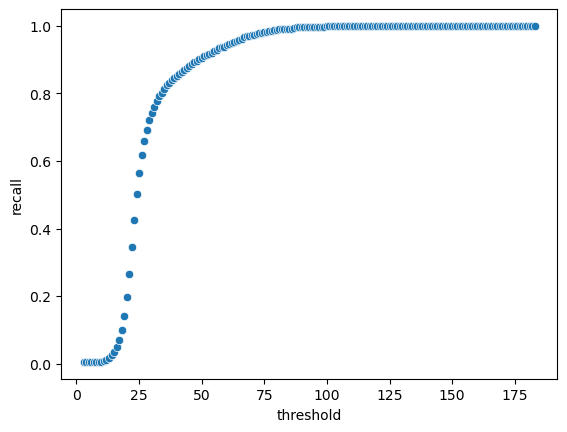

In [51]:
sns.scatterplot(results_df,x="threshold",y="recall")

<AxesSubplot: xlabel='threshold', ylabel='FPR'>

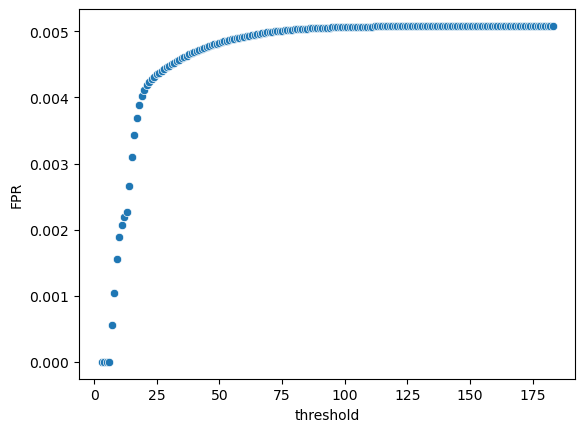

In [52]:
sns.scatterplot(results_df,x="threshold",y="FPR")

In [16]:
blast_column_labels = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"]

pattern_i = os.path.join(blast_dir,f"{label}.subsample_*.work")
dirlist = sorted(glob(pattern_i))
for sample_blast_dir in dirlist:
    print(sample_blast_dir)
    pattern_j = os.path.join(sample_blast_dir,f"{label}.*.blastn.out.gz")
    pathlist = sorted(glob(pattern_j))
    for sample_blast_path in pathlist:
        print(sample_blast_path)
        df = pd.read_csv(sample_blast_path,compression="gzip",header=None,sep="\t",names=blast_column_labels)
        break
    break

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.subsample_01.work
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.subsample_01.work/K562_clean.subsample_01.wordsize_11.maxtargetseqs_1000.evalue_10.dust_no.blastn.out.gz


In [34]:
candidate_dict = defaultdict(set)
for idx,row in tqdm(df.iterrows()):
    candidate_dict[row["qseqid"]].add(row["sseqid"])

565173it [00:10, 54661.04it/s]


In [25]:
display(df)

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,peak30144_Reversed,peak30144_Reversed,100.000,200,0,0,1,200,1,200,9.860000e-104,370.0
1,peak30144_Reversed,peak81101,100.000,16,0,0,74,89,82,97,1.900000e-01,30.7
2,peak30144_Reversed,peak47086,100.000,15,0,0,53,67,94,80,6.800000e-01,28.8
3,peak30144_Reversed,peak44997_Reversed,100.000,15,0,0,102,116,6,20,6.800000e-01,28.8
4,peak30144_Reversed,peak34978,90.476,21,2,0,78,98,126,146,6.800000e-01,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...
565168,peak61926_Reversed,peak68732_Reversed,100.000,13,0,0,28,40,53,65,8.800000e+00,25.1
565169,peak61926_Reversed,peak12735_Reversed,100.000,13,0,0,119,131,180,168,8.800000e+00,25.1
565170,peak61926_Reversed,peak69718,90.000,20,1,1,155,174,29,11,8.800000e+00,25.1
565171,peak61926_Reversed,peak57016_Reversed,100.000,13,0,0,101,113,124,136,8.800000e+00,25.1


# Processing recall results over complete dataset

In [6]:
blast_screen_dir = os.path.join(blast_dir,"K562_clean.complete.wordsize_screen")
pattern = os.path.join(blast_screen_dir,"K562_clean.complete.wordsize_*.work","recall")
for recall_dir in glob(pattern):
    pathlist = sorted(glob(os.path.join(recall_dir,"*.part_*.part_*.recall.csv.gz")))
    print(recall_dir,len(pathlist))
    dfs = []
    min_threshold = np.inf
    min_thresholds = []
    max_threshold = -np.inf
    max_thresholds = []
    for recall_path in tqdm(pathlist):
        df = pd.read_csv(recall_path,compression="gzip")
        df["threshold"] = df["threshold"].astype(int)
        df["word_size"] = int(os.path.basename(os.path.dirname(recall_dir)).split(".")[-2].split("_")[1])
        df = df.set_index("threshold")
        min_thresholds.append(df.index.min())
        if df.index.min() < min_threshold:
            min_threshold = df.index.min()
        max_thresholds.append(df.index.max())
        if df.index.max() > max_threshold:
            max_threshold = df.index.max()
        dfs.append(df)

    processed_dfs = []
    for df in tqdm(dfs):
        min_threshold_ = df.index.min()
        max_threshold_ = df.index.max()
        if min_threshold == min_threshold_ and max_threshold == max_threshold_: continue
        add_dict = {
            "threshold":[],
            "TP":[],
            "FP":[],
            "TN":[],
            "FN":[],
            "recall":[],
            "FPR":[],
            "word_size":[]
        }
        if min_threshold < min_threshold_:
            for threshold in range(min_threshold,min_threshold_,1):
                tp,fp,tn,fn,recall,fpr,word_size = list(df.loc[min_threshold_])
                add_dict["threshold"].append(threshold)
                add_dict["TP"].append(tp)
                add_dict["FP"].append(fp)
                add_dict["TN"].append(tn)
                add_dict["FN"].append(fn)
                add_dict["recall"].append(recall)
                add_dict["FPR"].append(fpr)
                add_dict["word_size"].append(word_size)
        if max_threshold_ < max_threshold:
            for threshold in range(max_threshold,max_threshold_,-1):
                tp,fp,tn,fn,recall,fpr,word_size = list(df.loc[max_threshold_])
                add_dict["threshold"].append(threshold)
                add_dict["TP"].append(tp)
                add_dict["FP"].append(fp)
                add_dict["TN"].append(tn)
                add_dict["FN"].append(fn)
                add_dict["recall"].append(recall)
                add_dict["FPR"].append(fpr)
                add_dict["word_size"].append(word_size)
                if fn > 0:
                    assert False

        add_df = pd.DataFrame(add_dict)
        add_df = add_df.set_index("threshold")

        df = pd.concat([df,add_df])
        df = df.sort_index()

        processed_dfs.append(df)

    df = pd.concat(processed_dfs)
    # display(df.head())
    recall_path = os.path.join(recall_dir,"recall.compiled.csv.gz")
    df.to_csv(recall_path,compression="gzip")

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen/K562_clean.complete.wordsize_5.work/recall 276


100%|██████████████████████████████████████████████| 276/276 [00:00<00:00, 434.27it/s]


/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen/K562_clean.complete.wordsize_6.work/recall 276


100%|██████████████████████████████████████████████| 276/276 [00:00<00:00, 556.46it/s]


/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen/K562_clean.complete.wordsize_4.work/recall 276


100%|██████████████████████████████████████████████| 276/276 [00:00<00:00, 547.65it/s]


In [7]:
recall_dfs = []
pattern = os.path.join(blast_screen_dir,"K562_clean.complete.wordsize_*.work","recall","recall.compiled.csv.gz")
for path in glob(pattern):
    recall_df = pd.read_csv(path)
    recall_dfs.append(recall_df)

In [8]:
path_i = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/recall/complete/K562_clean.complete.wordsize_7.recall/K562_clean.complete.wordsize_7.compiled_recall.csv.gz"
path_j = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/recall/complete/K562_clean.complete.wordsize_11.recall/K562_clean.complete.wordsize_11.compiled_recall.csv.gz"

recall_df = pd.read_csv(path_i)
recall_df["word_size"] = 7
recall_dfs.append(recall_df)

recall_df = pd.read_csv(path_j)
recall_df["word_size"] = 11
recall_dfs.append(recall_df)

In [9]:
recall_df = pd.concat(recall_dfs)
display(recall_df.head())
recall_df.shape

,threshold,TP,FP,TN,FN,recall,FPR,word_size
0,3,182746.0,0.0,0.0,99817254.0,0.001827,0.0,5.0
1,4,182746.0,0.0,0.0,99817254.0,0.001827,0.0,5.0
2,5,182746.0,0.0,2.0,99817252.0,0.001827,0.0,5.0
3,6,182746.0,0.0,356.0,99816898.0,0.001827,0.0,5.0
4,7,182746.0,0.0,28108.0,99789146.0,0.001828,0.0,5.0


(271260, 8)

<AxesSubplot: xlabel='threshold', ylabel='recall'>

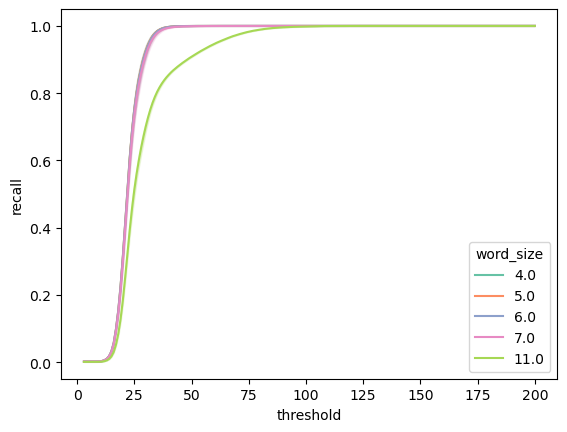

In [10]:
sns.lineplot(recall_df,x="threshold",y="recall",hue="word_size",palette="Set2")

In [11]:
int(os.path.basename(os.path.dirname(recall_dir)).split(".")[-2].split("_")[1])

10

In [106]:
w = 7
word_size = f"wordsize_{w}"
dataset =  "K562_clean"
pattern = os.path.join(recall_dir,"complete",f"{dataset}.complete.{word_size}.recall",f"{dataset}.complete.{word_size}.*.recall.csv.gz")
pathlist = sorted(glob(pattern))

In [107]:
df = pd.read_csv(pathlist[0],compression="gzip")
df

,threshold,TP,FP,TN,FN,recall,FPR
0,4.0,170174,0,0,99829826,0.001702,0.000000
1,5.0,170174,0,2,99829824,0.001702,0.000000
2,6.0,170174,0,356,99829470,0.001702,0.000000
3,7.0,170174,0,28108,99801718,0.001702,0.000000
4,8.0,170174,0,703812,99126014,0.001714,0.000000
...,...,...,...,...,...,...,...
192,196.0,10000,160174,99829826,0,1.000000,0.001602
193,197.0,10000,160174,99829826,0,1.000000,0.001602
194,198.0,10000,160174,99829826,0,1.000000,0.001602
195,199.0,10000,160174,99829826,0,1.000000,0.001602


In [113]:
dfs = []
min_threshold = np.inf
min_thresholds = []
max_threshold = -np.inf
max_thresholds = []
for recall_path in tqdm(pathlist):
    df = pd.read_csv(recall_path,compression="gzip")
    df["threshold"] = df["threshold"].astype(int)
    df = df.set_index("threshold")
    min_thresholds.append(df.index.min())
    if df.index.min() < min_threshold:
        min_threshold = df.index.min()
    max_thresholds.append(df.index.max())
    if df.index.max() > max_threshold:
        max_threshold = df.index.max()
    dfs.append(df)

100%|██████████████████████████████████████████████| 276/276 [00:00<00:00, 441.12it/s]


In [116]:
np.max(min_thresholds),np.min(max_thresholds)

(5, 131)

In [109]:
min_threshold,max_threshold

(3, 200)

In [110]:
processed_dfs = []
for df in tqdm(dfs):
    min_threshold_ = df.index.min()
    max_threshold_ = df.index.max()
    if min_threshold == min_threshold_ and max_threshold == max_threshold_: continue
    add_dict = {
        "threshold":[],
        "TP":[],
        "FP":[],
        "TN":[],
        "FN":[],
        "recall":[],
        "FPR":[]
    }
    if min_threshold < min_threshold_:
        for threshold in range(min_threshold,min_threshold_,1):
            tp,fp,tn,fn,recall,fpr = list(df.loc[min_threshold_])
            add_dict["threshold"].append(threshold)
            add_dict["TP"].append(tp)
            add_dict["FP"].append(fp)
            add_dict["TN"].append(tn)
            add_dict["FN"].append(fn)
            add_dict["recall"].append(recall)
            add_dict["FPR"].append(fpr)
    if max_threshold_ < max_threshold:
        for threshold in range(max_threshold,max_threshold_,-1):
            tp,fp,tn,fn,recall,fpr = list(df.loc[max_threshold_])
            add_dict["threshold"].append(threshold)
            add_dict["TP"].append(tp)
            add_dict["FP"].append(fp)
            add_dict["TN"].append(tn)
            add_dict["FN"].append(fn)
            add_dict["recall"].append(recall)
            add_dict["FPR"].append(fpr)
            if fn > 0:
                assert False

    add_df = pd.DataFrame(add_dict)
    add_df = add_df.set_index("threshold")

    df = pd.concat([df,add_df])
    df = df.sort_index()

    processed_dfs.append(df)

100%|██████████████████████████████████████████████| 276/276 [00:00<00:00, 698.77it/s]


In [111]:
df = pd.concat(processed_dfs)
display(df.head())
df.shape

,TP,FP,TN,FN,recall,FPR
threshold,,,,,,
3,170174.0,0.0,0.0,99829826.0,0.001702,0.0
4,170174.0,0.0,0.0,99829826.0,0.001702,0.0
5,170174.0,0.0,2.0,99829824.0,0.001702,0.0
6,170174.0,0.0,356.0,99829470.0,0.001702,0.0
7,170174.0,0.0,28108.0,99801718.0,0.001702,0.0


(54252, 6)

In [112]:
outpath = os.path.join(os.path.dirname(pathlist[0]),f"{dataset}.complete.{word_size}.compiled_recall.csv.gz")
df.to_csv(outpath,compression="gzip")

# Formatting calculation of SW scores for candidates

In [21]:
blast_path = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/K562_clean.blastn.out.gz"
columns = [
    "qseqid","sseqid","pident","length","mismatch",
    "gapopen","qstart","qend","sstart","send","evalue",
    "bitscore","score","positive","gaps"
]
candidate_dict = defaultdict(set)
for chunk_df in tqdm(pd.read_csv(blast_path,compression="gzip",header=None,sep="\t",names=columns,chunksize=250_000)):
    for query_id,candidates in chunk_df.groupby("qseqid")["sseqid"].apply(set).items():
        candidate_dict[query_id].update(candidates)

460it [02:21,  3.25it/s]


In [22]:
len(candidate_dict)

226253

In [23]:
114763179/100

1147631.79

In [19]:

for query_id,candidates in chunk_df.groupby("qseqid")["sseqid"].apply(set).items():
    print(query_id,len(candidates))
    print(candidates)
    break

peak10 37
{'peak87444_Reversed', 'peak68026_Reversed', 'peak2832', 'peak64621_Reversed', 'peak33267', 'peak45817_Reversed', 'peak64746', 'peak35970_Reversed', 'peak38707', 'peak32552_Reversed', 'peak593', 'peak72453', 'peak16749_Reversed', 'peak28473', 'peak10', 'peak66633', 'peak14567', 'ENSG00000105464', 'peak73003_Reversed', 'peak80597_Reversed', 'peak84294_Reversed', 'peak967', 'ENSG00000142789', 'peak19291', 'ENSG00000002745', 'peak69577_Reversed', 'ENSG00000100003_Reversed', 'HBE1_5214', 'peak28619_Reversed', 'peak69586_Reversed', 'peak53020_Reversed', 'peak50976', 'peak54602', 'peak6212', 'peak24113', 'ENSG00000211643_Reversed', 'peak33327_Reversed'}


In [ ]:
grouped = chunk_df.groupby("qseqid")["sseqid"].apply(set)
    
    # Update the candidate_dict
    for qseqid, sseqid_set in grouped.items():
        candidate_dict[qseqid].update(sseqid_set)

# Filtering to capture all pairwise comparisons 

In [44]:
sw_dir = "/home/brett/work/OrthogonalTrainValSplits/distances/K562_clean.smith_waterman.1121"

In [21]:
complete_recall_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/recall/complete/K562_clean.complete.wordsize_7.recall'

In [37]:
def load_candidates_list(path):
    with gzip.open(path,"rt") as handle:
        candidates = handle.read().splitlines()
    return candidates

Submitting job script to filter all pairwise comparisons to only those above a SW score of 30

In [22]:
# pattern = os.path.join(sw_dir,"*.pairwise_comparisons.batch.txt.gz")
# complete_recall_dir = os.path.join(recall_dir,"complete","K562_clean.complete.wordsize_7.recall")
# for path in tqdm(glob(pattern)):
#     df = pd.read_csv(path,compression="gzip")
#     partition_label = os.path.basename(path).replace("K562_clean.","").replace(".pairwise_comparisons.batch.txt.gz","")
#     candidates_path = os.path.join(complete_recall_dir,f"K562_clean.complete.wordsize_7.{partition_label}.candidates.txt.gz")
#     candidates = load_candidates_list(candidates_path)
#     df["candidate"] = candidates
#     break

In [25]:
dfs = []

pattern = os.path.join(sw_dir,"*.pairwise_comparisons.batch.filter30.txt.gz")
pathlist = sorted(glob(pattern))
for path in tqdm(pathlist):
    dfs.append(pd.read_csv(path,compression="gzip"))

df = pd.concat(dfs)
del dfs

outpath = os.path.join(sw_dir,"K562_clean.pairwise_comparisons.compiled.filter30.txt.gz")
df.to_csv(outpath,compression="gzip",index=False)

display(df.head())
df.shape

100%|██████████████████████████████████████████████████| 276/276 [00:17<00:00, 16.01it/s]


,id_i,id_j,sw,candidate
0,peak10,peak10,200.0,1
1,peak10_Reversed,peak10_Reversed,200.0,1
2,peak1000,peak1000,200.0,1
3,peak1000,peak1020_Reversed,174.0,1
4,peak1000,peak1025_Reversed,73.0,1


(23095083, 4)

# Computing alignment scores of BLASTN candidates

In [5]:
fasta_path

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.fa.gz'

In [6]:
blast_path = os.path.join(blast_dir,"K562_clean.complete.wordsize_7.work","K562_clean.blastn.out")
blast_path

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/K562_clean.blastn.out'

In [7]:
partitioned_blast_dir = os.path.join(blast_dir,"K562_clean.complete.wordsize_7.work","blast_partitions")
partitioned_blast_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions'

In [9]:
%%bash

BLAST_PATH=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/K562_clean.blastn.out
PARTITIONED_BLAST_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions
mkdir -p $PARTITIONED_BLAST_DIR
cd $PARTITIONED_BLAST_DIR

split -l 25000000 -a 4 $BLAST_PATH K562_clean.blastn.partition_

In [11]:
%%bash

FASTA_PATH=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.fa.gz
PARTITIONED_BLAST_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions
SCORE_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/smith_waterman

for PARTITIONED_BLAST_PATH in $PARTITIONED_BLAST_DIR/K562_clean.blastn.partition_*
do
    echo $PARTITIONED_BLAST_PATH
    LABEL=$( basename $PARTITIONED_BLAST_PATH )
    PARTITIONED_SCORE_PATH=$SCORE_DIR/${LABEL}.smith_waterman.csv.gz
    qsub pairwise_sw_comparisons_blast_candidates.sh $FASTA_PATH $PARTITIONED_BLAST_PATH $PARTITIONED_SCORE_PATH
done

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions/K562_clean.blastn.partition_aaaa
requested Hard Resources
  memory (s_vmem): 8G = The job requires 8GB of memory per slot.
  slots (def_slot): 16 = The job requires 1600% of CPU.
  total memory: 128G = The job requires 128GB of memory.
  Resource list: arm
Your job 108434627 ("bkSW") has been submitted
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions/K562_clean.blastn.partition_aaab
requested Hard Resources
  memory (s_vmem): 8G = The job requires 8GB of memory per slot.
  slots (def_slot): 16 = The job requires 1600% of CPU.
  total memory: 128G = The job requires 128GB of memory.
  Resource list: arm
Your job 108434629 ("bkSW") has been submitted
/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions/K562_clean.blastn.partition_aaac
requeste

In [14]:
%%time

fasta_dict = load_fasta_as_dictionary(fasta_path)
ids = list(fasta_dict)
idset = set(ids)
N = len(ids)
print(f"{N} total sequences")

226253it [00:01, 192799.63it/s]

226253 total sequences
CPU times: user 977 ms, sys: 28.9 ms, total: 1.01 s
Wall time: 2.5 s


In [17]:
filtered_idset = set()
for seq_id in tqdm(ids):
    complementary_id = get_complementary_id(seq_id)
    if complementary_id in idset:
        filtered_idset.add(seq_id)
        filtered_idset.add(complementary_id)

len(filtered_idset)

100%|██████████████████████████████████████████████████████████████████| 226253/226253 [00:00<00:00, 1716558.94it/s]


223052

In [98]:
threshold = 60
columns = ["id_i","id_j","smith_waterman_score"]
score_dfs = []
pattern = os.path.join(score_dir,"K562_clean.blastn.partition_*.smith_waterman.csv.gz")
for score_path in tqdm(sorted(glob(pattern))):
    score_df = pd.read_csv(score_path,names=columns)
    score_df = score_df[
        (score_df["smith_waterman_score"] >= threshold) & \
        (score_df["id_i"] != score_df["id_j"]) & \
        (score_df["id_i"].isin(filtered_idset)) & \
        (score_df["id_j"].isin(filtered_idset))
    ]
    score_dfs.append(score_df)
score_df = pd.concat(score_dfs)

100%|██████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.78s/it]


In [91]:
score_df.shape

(8496639, 3)

In [99]:
score_df['pair'] = score_df[['id_i', 'id_j']].apply(lambda x: tuple(sorted(x)), axis=1)
score_df = score_df.drop_duplicates(subset='pair')
# pairs_dict = dict(zip(score_df['pair'],score_df['score']))
score_df

,id_i,id_j,smith_waterman_score,pair
26,peak10,peak33267,138.0,"(peak10, peak33267)"
34,peak10,peak64621_Reversed,161.0,"(peak10, peak64621_Reversed)"
38,peak1000,peak5501,72.0,"(peak1000, peak5501)"
43,peak1000,peak1025_Reversed,73.0,"(peak1000, peak1025_Reversed)"
50,peak1000,peak5435,89.0,"(peak1000, peak5435)"
...,...,...,...,...
11881738,RBM38_958_Reversed,RBM38_9724_Reversed,61.0,"(RBM38_958_Reversed, RBM38_9724_Reversed)"
11903625,RBM38_9670,RBM38_9724_Reversed,74.0,"(RBM38_9670, RBM38_9724_Reversed)"
11907599,RBM38_9670_Reversed,RBM38_9724,74.0,"(RBM38_9670_Reversed, RBM38_9724)"
11917306,RBM38_9724,RBM38_994,90.0,"(RBM38_9724, RBM38_994)"


In [58]:
blast_columns = [
    "qseqid","sseqid","pident","length","mismatch",
    "gapopen","qstart","qend","sstart","send","evalue",
    "bitscore","score","positive","gaps"
]
pattern = os.path.join(partitioned_blast_dir,"*")
for partitioned_blast_path in sorted(glob(pattern)):
    partition_label = os.path.basename(partitioned_blast_path)
    if partition_label.endswith(".augmented.tsv.gz"): continue
    print(os.path.basename(partitioned_blast_path))
    partitioned_blast_df = pd.read_csv(partitioned_blast_path,names=blast_columns,sep="\t")
    print(partitioned_blast_df.shape)
    partitioned_blast_df['pair'] = partitioned_blast_df[['qseqid','sseqid']].apply(lambda x: tuple(sorted(x)), axis=1)
    partitioned_blast_df = partitioned_blast_df.merge(score_df[['pair','smith_waterman_score']],on='pair',how='left')
    partitioned_blast_df = partitioned_blast_df[~partitioned_blast_df["smith_waterman_score"].isna()]
    print(partitioned_blast_df.shape)
    augmented_blast_path = partitioned_blast_path+".augmented.tsv.gz"
    partitioned_blast_df.to_csv(augmented_blast_path,compression="gzip",sep="\t",index=False)
    del partitioned_blast_df


K562_clean.blastn.partition_aaaa


AssertionError: 

In [56]:
pattern = os.path.join(partitioned_blast_dir,"*.augmented.tsv.gz")
augmented_blast_dfs = []
for augmented_blast_path in sorted(glob(pattern)):
    blast_df = pd.read_csv(augmented_blast_path,sep="\t")
    augmented_blast_dfs.append(blast_df[["qseqid","sseqid","score","pair","smith_waterman_score"]].copy())
    del blast_df

augmented_blast_df = pd.concat(augmented_blast_dfs)
augmented_blast_df = augmented_blast_df.drop_duplicates(subset='pair')
filtered_blast_path = os.path.join(blast_dir,"blastn_results.filtered_candidates.tsv.gz")
augmented_blast_df.to_csv(filtered_blast_path,compression="gzip",sep="\t",index=False)

display(augmented_blast_df.head())
print(augmented_blast_df.shape)



,qseqid,sseqid,score,pair,smith_waterman_score
0,peak10,peak64621_Reversed,161,"('peak10', 'peak64621_Reversed')",161.0
1,peak10,peak33267,138,"('peak10', 'peak33267')",138.0
2,peak10_Reversed,peak64621,161,"('peak10_Reversed', 'peak64621')",161.0
3,peak10_Reversed,peak33267_Reversed,138,"('peak10_Reversed', 'peak33267_Reversed')",138.0
4,peak1000,peak1020_Reversed,174,"('peak1000', 'peak1020_Reversed')",174.0


(4248316, 5)


## Filtering based on BLAST heuristic alignment score

In [37]:
partitioned_blast_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions'

In [38]:
blast_columns = [
    "qseqid","sseqid","pident","length","mismatch",
    "gapopen","qstart","qend","sstart","send","evalue",
    "bitscore","score","positive","gaps"
]
pattern = os.path.join(partitioned_blast_dir,"*")
for partitioned_blast_path in sorted(glob(pattern)):
    partition_label = os.path.basename(partitioned_blast_path)
    if partition_label.endswith(".augmented.tsv.gz"): continue
    if partition_label.endswith(".augmented.heuristic_score.tsv.gz"): continue
    if partition_label.endswith(".augmented.corrected_blastn_score.tsv.gz"): continue
    if partition_label.endswith(".augmented.corrected_blastn_score.tsv.gz.filtered.corrected_blastn_score.tsv.gz"): continue

    augmented_blast_path = partitioned_blast_path+".augmented.corrected_blastn_score.tsv.gz"
    # if os.path.exists(augmented_blast_path): continue

    print(os.path.basename(partitioned_blast_path))
    partitioned_blast_df = pd.read_csv(partitioned_blast_path,names=blast_columns,sep="\t")
    # print(partitioned_blast_df.shape)
    # partitioned_blast_df = partitioned_blast_df[partitioned_blast_df["score"] >= 60]

    partitioned_blast_df["blast_score_corrected"] = partitioned_blast_df["positive"]-partitioned_blast_df["mismatch"]-partitioned_blast_df["gapopen"]*2-(partitioned_blast_df["gaps"]-partitioned_blast_df["gapopen"])

    # print(partitioned_blast_df.shape)
    # augmented_blast_path = partitioned_blast_path+".augmented.corrected_blastn_score.tsv.gz"
    # partitioned_blast_df.to_csv(augmented_blast_path,compression="gzip",sep="\t",index=False)
    # del partitioned_blast_df
    assert False

K562_clean.blastn.partition_aaaa


AssertionError: 

In [39]:
partitioned_blast_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,score,positive,gaps,blast_score_corrected
0,peak10,peak10,100.000,200,0,0,1,200,1,200,7.930000e-78,288.0,200,200,0,200
1,peak10,peak64621_Reversed,90.452,199,19,0,1,199,2,200,4.650000e-61,232.0,161,180,0,161
2,peak10,peak33267,86.316,190,26,0,11,200,4,193,3.600000e-51,199.0,138,164,0,138
3,peak10,peak38707,81.818,33,6,0,51,83,28,60,7.300000e-01,32.6,21,27,0,21
4,peak10,peak68026_Reversed,83.333,30,5,0,56,85,38,67,2.000000e+00,31.1,20,25,0,20


In [40]:
partitioned_blast_df["blast_score_corrected_2"] = (
    1*partitioned_blast_df["positive"] - 
    1*partitioned_blast_df["mismatch"] - 
    2*partitioned_blast_df["gapopen"] - 
    1*(partitioned_blast_df["gaps"]-partitioned_blast_df["gapopen"])
)


In [41]:
np.all(partitioned_blast_df["blast_score_corrected_2"] == partitioned_blast_df["blast_score_corrected"])

True

In [13]:
pattern = os.path.join(partitioned_blast_dir,"*.augmented.corrected_blastn_score.tsv.gz")
for partitioned_blast_path in sorted(glob(pattern)):
    partition_label = os.path.basename(partitioned_blast_path)
    filtered_blast_path = partitioned_blast_path+".filtered.corrected_blastn_score.tsv.gz"
    if os.path.exists(filtered_blast_path): continue

    print(os.path.basename(partitioned_blast_path))
    partitioned_blast_df = pd.read_csv(partitioned_blast_path,sep="\t")
    print(partitioned_blast_df.shape)
    partitioned_blast_df = partitioned_blast_df[partitioned_blast_df["blast_score_corrected"] >= 60]
    print(partitioned_blast_df.shape)

    partitioned_blast_df.to_csv(filtered_blast_path,compression="gzip",sep="\t",index=False)
    del partitioned_blast_df

K562_clean.blastn.partition_aaaa.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaaa.augmented.corrected_blastn_score.tsv.gz
(25000000, 16)
(1986621, 16)
K562_clean.blastn.partition_aaab.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaab.augmented.corrected_blastn_score.tsv.gz
(25000000, 16)
(1796267, 16)
K562_clean.blastn.partition_aaac.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaac.augmented.corrected_blastn_score.tsv.gz
(25000000, 16)
(2018486, 16)
K562_clean.blastn.partition_aaad.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaad.augmented.corrected_blastn_score.tsv.gz
(25000000, 16)
(1859715, 16)
K562_clean.blastn.partition_aaae.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaae.augmented.corrected_blastn_score.tsv.gz
(14763179, 16)
(1366244, 16)


In [16]:
pattern = os.path.join(partitioned_blast_dir,"*.filtered.corrected_blastn_score.tsv.gz")
heuristic_blast_dfs = []
for heuristic_augmented_blast_path in sorted(glob(pattern)):
    heuristic_blast_df = pd.read_csv(heuristic_augmented_blast_path,sep="\t")
    heuristic_blast_dfs.append(heuristic_blast_df[["qseqid","sseqid","blast_score_corrected"]].copy())
    del heuristic_blast_df

heuristic_augmented_blast_df = pd.concat(heuristic_blast_dfs)
heuristic_augmented_blast_df['pair'] = heuristic_augmented_blast_df[['qseqid','sseqid']].apply(lambda x: tuple(sorted(x)), axis=1)
heuristic_augmented_blast_df = heuristic_augmented_blast_df.drop_duplicates(subset='pair')
heuristic_filtered_blast_path = os.path.join(blast_dir,"blastn_results.corrected_blast_score.filtered_candidates.tsv.gz")
heuristic_augmented_blast_df.to_csv(heuristic_filtered_blast_path,compression="gzip",sep="\t",index=False)

display(heuristic_augmented_blast_df.head())
print(heuristic_augmented_blast_df.shape)


,qseqid,sseqid,blast_score_corrected,pair
0,peak10,peak10,200,"(peak10, peak10)"
1,peak10,peak64621_Reversed,161,"(peak10, peak64621_Reversed)"
2,peak10,peak33267,138,"(peak10, peak33267)"
3,peak10_Reversed,peak10_Reversed,200,"(peak10_Reversed, peak10_Reversed)"
4,peak10_Reversed,peak64621,161,"(peak10_Reversed, peak64621)"


(4616010, 4)


In [ ]:
4226413

# Correlation between Corrected BLAST scores to SW scores for candidate pairs

In [54]:
os.path.join(blast_dir,"K562_clean.complete.wordsize_screen","*.work","K562_clean.blastn.out","K562_clean.blastn.out")

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen/*.work/K562_clean.blastn.out/K562_clean.blastn.out'

In [39]:
blast_columns = [
    "qseqid","sseqid","pident","length","mismatch",
    "gapopen","qstart","qend","sstart","send","evalue",
    "bitscore","score","positive","gaps"
]

reward    = 1
penalty   = 1
gapopen   = 2
gapextend = 1

max_blast_score_dict = defaultdict(float)

pattern = os.path.join(blast_dir,"K562_clean.complete.wordsize_screen","*.work","K562_clean.blastn.out","K562_clean.blastn.out")
blast_pathlist = glob(pattern)
for blast_path in blast_pathlist:
    print(blast_path)
    for partial_blast_df in tqdm(pd.read_csv(blast_path,names=blast_columns,sep="\t",chunksize=250_000)):
        partial_blast_df["corrected_blast_score"] = (
            reward*partial_blast_df["positive"] +
            penalty*partial_blast_df["mismatch"] -
            gapopen*partial_blast_df["gapopen"] -
            gapextend*(partial_blast_df["gaps"] - partial_blast_df["gapopen"])
        )
        partial_blast_df['pair'] = partial_blast_df[['qseqid','sseqid']].apply(lambda x: tuple(sorted(x)),axis=1)
        partial_blast_df = partial_blast_df[["pair","corrected_blast_score"]]
        for pair,score in zip(partial_blast_df["pair"],partial_blast_df["corrected_blast_score"]):
            if score > max_blast_score_dict[pair]:
                max_blast_score_dict[pair] = score
    break

/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen/K562_clean.complete.wordsize_5.work/K562_clean.blastn.out/K562_clean.blastn.out


188it [05:47,  2.55s/it]IOStream.flush timed out
196it [06:27,  2.69s/it]IOStream.flush timed out
202it [07:19,  4.06s/it]IOStream.flush timed out
203it [07:49, 11.79s/it]IOStream.flush timed out
205it [08:34, 15.54s/it]IOStream.flush timed out
211it [09:16,  4.85s/it]IOStream.flush timed out
214it [09:50,  6.98s/it]IOStream.flush timed out
216it [10:12,  9.08s/it]IOStream.flush timed out
233it [11:22,  8.00s/it]IOStream.flush timed out
284it [13:28,  6.22s/it]IOStream.flush timed out
496it [20:11,  2.44s/it]


In [40]:
len(max_blast_score_dict)

51526641

In [52]:
sw_dir = "/home/brett/work/OrthogonalTrainValSplits/distances/K562_clean.smith_waterman.1121"
columns = ["id_i","id_j","smith_waterman_score"]
score_dfs = []
pattern = os.path.join(sw_dir,"K562_clean.part_*.part_*.pairwise_comparisons.batch.txt.gz")
for score_path in tqdm(sorted(glob(pattern))):
    print(score_path)
    for partial_score_df in pd.read_csv(score_path,names=columns,chunksize=500_000):
        partial_score_df['pair'] = partial_score_df[['id_i','id_j']].apply(lambda x: tuple(sorted(x)),axis=1)
        display(partial_score_df)
        break
    break

  0%|                                                                                      | 0/276 [00:00<?, ?it/s]

/home/brett/work/OrthogonalTrainValSplits/distances/K562_clean.smith_waterman.1121/K562_clean.part_001.part_001.pairwise_comparisons.batch.txt.gz


/tmp/ipykernel_2407036/2586346320.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for partial_score_df in pd.read_csv(score_path,names=columns,chunksize=500_000):


,id_i,id_j,smith_waterman_score,pair
0,id_i,id_j,sw,"(id_i, id_j)"
1,peak10,peak10,200.0,"(peak10, peak10)"
2,peak10,peak10_Reversed,11.0,"(peak10, peak10_Reversed)"
3,peak10,peak1000,10.0,"(peak10, peak1000)"
4,peak10,peak1000_Reversed,9.0,"(peak10, peak1000_Reversed)"
...,...,...,...,...
499995,peak10020_Reversed,peak14661_Reversed,9.0,"(peak10020_Reversed, peak14661_Reversed)"
499996,peak10020_Reversed,peak14662,9.0,"(peak10020_Reversed, peak14662)"
499997,peak10020_Reversed,peak14662_Reversed,11.0,"(peak10020_Reversed, peak14662_Reversed)"
499998,peak10020_Reversed,peak14663,12.0,"(peak10020_Reversed, peak14663)"


  0%|                                                                                      | 0/276 [00:03<?, ?it/s]


In [50]:
partial_score_df[partial_score_df.pair.isin(max_blast_score_dict)].shape

(1340, 4)

In [51]:
partial_score_df = partial_score_df[partial_score_df.pair.isin(max_blast_score_dict)]
partial_score_df["corrected_blast_score"] = [max_blast_score_dict[pair] for pair in partial_score_df["pair"]]
partial_score_df

,id_i,id_j,sw,pair,corrected_blast_score
0,peak10,peak10,200.0,"(peak10, peak10)",200
9789,peak10,peak14567,18.0,"(peak10, peak14567)",23
10001,peak10_Reversed,peak10_Reversed,200.0,"(peak10_Reversed, peak10_Reversed)",200
19790,peak10_Reversed,peak14567_Reversed,18.0,"(peak10_Reversed, peak14567_Reversed)",23
20002,peak1000,peak1000,200.0,"(peak1000, peak1000)",200
...,...,...,...,...,...
488965,peak10020,peak14177_Reversed,17.0,"(peak10020, peak14177_Reversed)",17
490049,peak10020_Reversed,peak10020_Reversed,200.0,"(peak10020_Reversed, peak10020_Reversed)",200
490747,peak10020_Reversed,peak10345_Reversed,23.0,"(peak10020_Reversed, peak10345_Reversed)",46
495512,peak10020_Reversed,peak1256,17.0,"(peak10020_Reversed, peak1256)",19


In [53]:
partial_score_df

,id_i,id_j,smith_waterman_score,pair
0,id_i,id_j,sw,"(id_i, id_j)"
1,peak10,peak10,200.0,"(peak10, peak10)"
2,peak10,peak10_Reversed,11.0,"(peak10, peak10_Reversed)"
3,peak10,peak1000,10.0,"(peak10, peak1000)"
4,peak10,peak1000_Reversed,9.0,"(peak10, peak1000_Reversed)"
...,...,...,...,...
499995,peak10020_Reversed,peak14661_Reversed,9.0,"(peak10020_Reversed, peak14661_Reversed)"
499996,peak10020_Reversed,peak14662,9.0,"(peak10020_Reversed, peak14662)"
499997,peak10020_Reversed,peak14662_Reversed,11.0,"(peak10020_Reversed, peak14662_Reversed)"
499998,peak10020_Reversed,peak14663,12.0,"(peak10020_Reversed, peak14663)"


In [8]:
blast_dfs = []

pattern = os.path.join(partitioned_blast_dir,"*.augmented.corrected_blastn_score.tsv.gz")
for partitioned_blast_path in sorted(glob(pattern)):
    print(os.path.basename(partitioned_blast_path))
    partitioned_blast_df = pd.read_csv(partitioned_blast_path,sep="\t")
    blast_dfs.append(partitioned_blast_df)
    del partitioned_blast_df
blast_df = pd.concat(blast_dfs)
display(blast_df.head())
print(blast_df.shape)

K562_clean.blastn.partition_aaaa.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaab.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaac.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaad.augmented.corrected_blastn_score.tsv.gz
K562_clean.blastn.partition_aaae.augmented.corrected_blastn_score.tsv.gz


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,score,positive,gaps,blast_score_corrected
0,peak10,peak10,100.000,200,0,0,1,200,1,200,7.930000e-78,288.0,200,200,0,200
1,peak10,peak64621_Reversed,90.452,199,19,0,1,199,2,200,4.650000e-61,232.0,161,180,0,161
2,peak10,peak33267,86.316,190,26,0,11,200,4,193,3.600000e-51,199.0,138,164,0,138
3,peak10,peak38707,81.818,33,6,0,51,83,28,60,7.300000e-01,32.6,21,27,0,21
4,peak10,peak68026_Reversed,83.333,30,5,0,56,85,38,67,2.000000e+00,31.1,20,25,0,20


(114763179, 16)


In [9]:
blast_df['pair'] = blast_df[['qseqid','sseqid']].apply(lambda x: tuple(sorted(x)), axis=1)
blast_df = blast_df.drop_duplicates(subset='pair')
blast_df.shape

(47867361, 17)

In [18]:
threshold = 30
columns = ["id_i","id_j","smith_waterman_score"]
score_dfs = []
pattern = os.path.join(score_dir,"K562_clean.blastn.partition_*.smith_waterman.csv.gz")
for score_path in tqdm(sorted(glob(pattern))):
    score_df = pd.read_csv(score_path,names=columns)
    score_df = score_df[
        (score_df["smith_waterman_score"] > 30) & \
        (score_df["id_i"].isin(filtered_idset)) & \
        (score_df["id_j"].isin(filtered_idset))
    ]
    score_dfs.append(score_df)
score_df = pd.concat(score_dfs)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.58s/it]


In [19]:
score_df.shape

(36633202, 3)

In [20]:
score_df['pair'] = score_df[['id_i','id_j']].apply(lambda x: tuple(sorted(x)), axis=1)
score_df = score_df.drop_duplicates(subset='pair')
score_df.shape

(18428139, 4)

In [21]:
df = pd.merge(score_df,blast_df,on="pair",how="left")
display(df.head())
print(df.shape)

,id_i,id_j,smith_waterman_score,pair,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,score,positive,gaps,blast_score_corrected
0,peak10,peak10,200.0,"(peak10, peak10)",peak10,peak10,100.000,200,0,0,1,200,1,200,7.930000e-78,288.0,200,200,0,200
1,peak10,peak33267,138.0,"(peak10, peak33267)",peak10,peak33267,86.316,190,26,0,11,200,4,193,3.600000e-51,199.0,138,164,0,138
2,peak10,peak64621_Reversed,161.0,"(peak10, peak64621_Reversed)",peak10,peak64621_Reversed,90.452,199,19,0,1,199,2,200,4.650000e-61,232.0,161,180,0,161
3,peak1000,peak5501,72.0,"(peak1000, peak5501)",peak1000,peak5501,76.056,142,20,3,1,130,57,196,4.500000e-21,99.7,68,108,14,71
4,peak1000,peak1025_Reversed,73.0,"(peak1000, peak1025_Reversed)",peak1000,peak1025_Reversed,73.913,161,27,5,3,150,1,159,1.210000e-20,98.3,67,119,15,72


(18428139, 20)


In [22]:
df = df[["id_i","id_j","smith_waterman_score","blast_score_corrected"]]
display(df.head())

,id_i,id_j,smith_waterman_score,blast_score_corrected
0,peak10,peak10,200.0,200
1,peak10,peak33267,138.0,138
2,peak10,peak64621_Reversed,161.0,161
3,peak1000,peak5501,72.0,71
4,peak1000,peak1025_Reversed,73.0,72


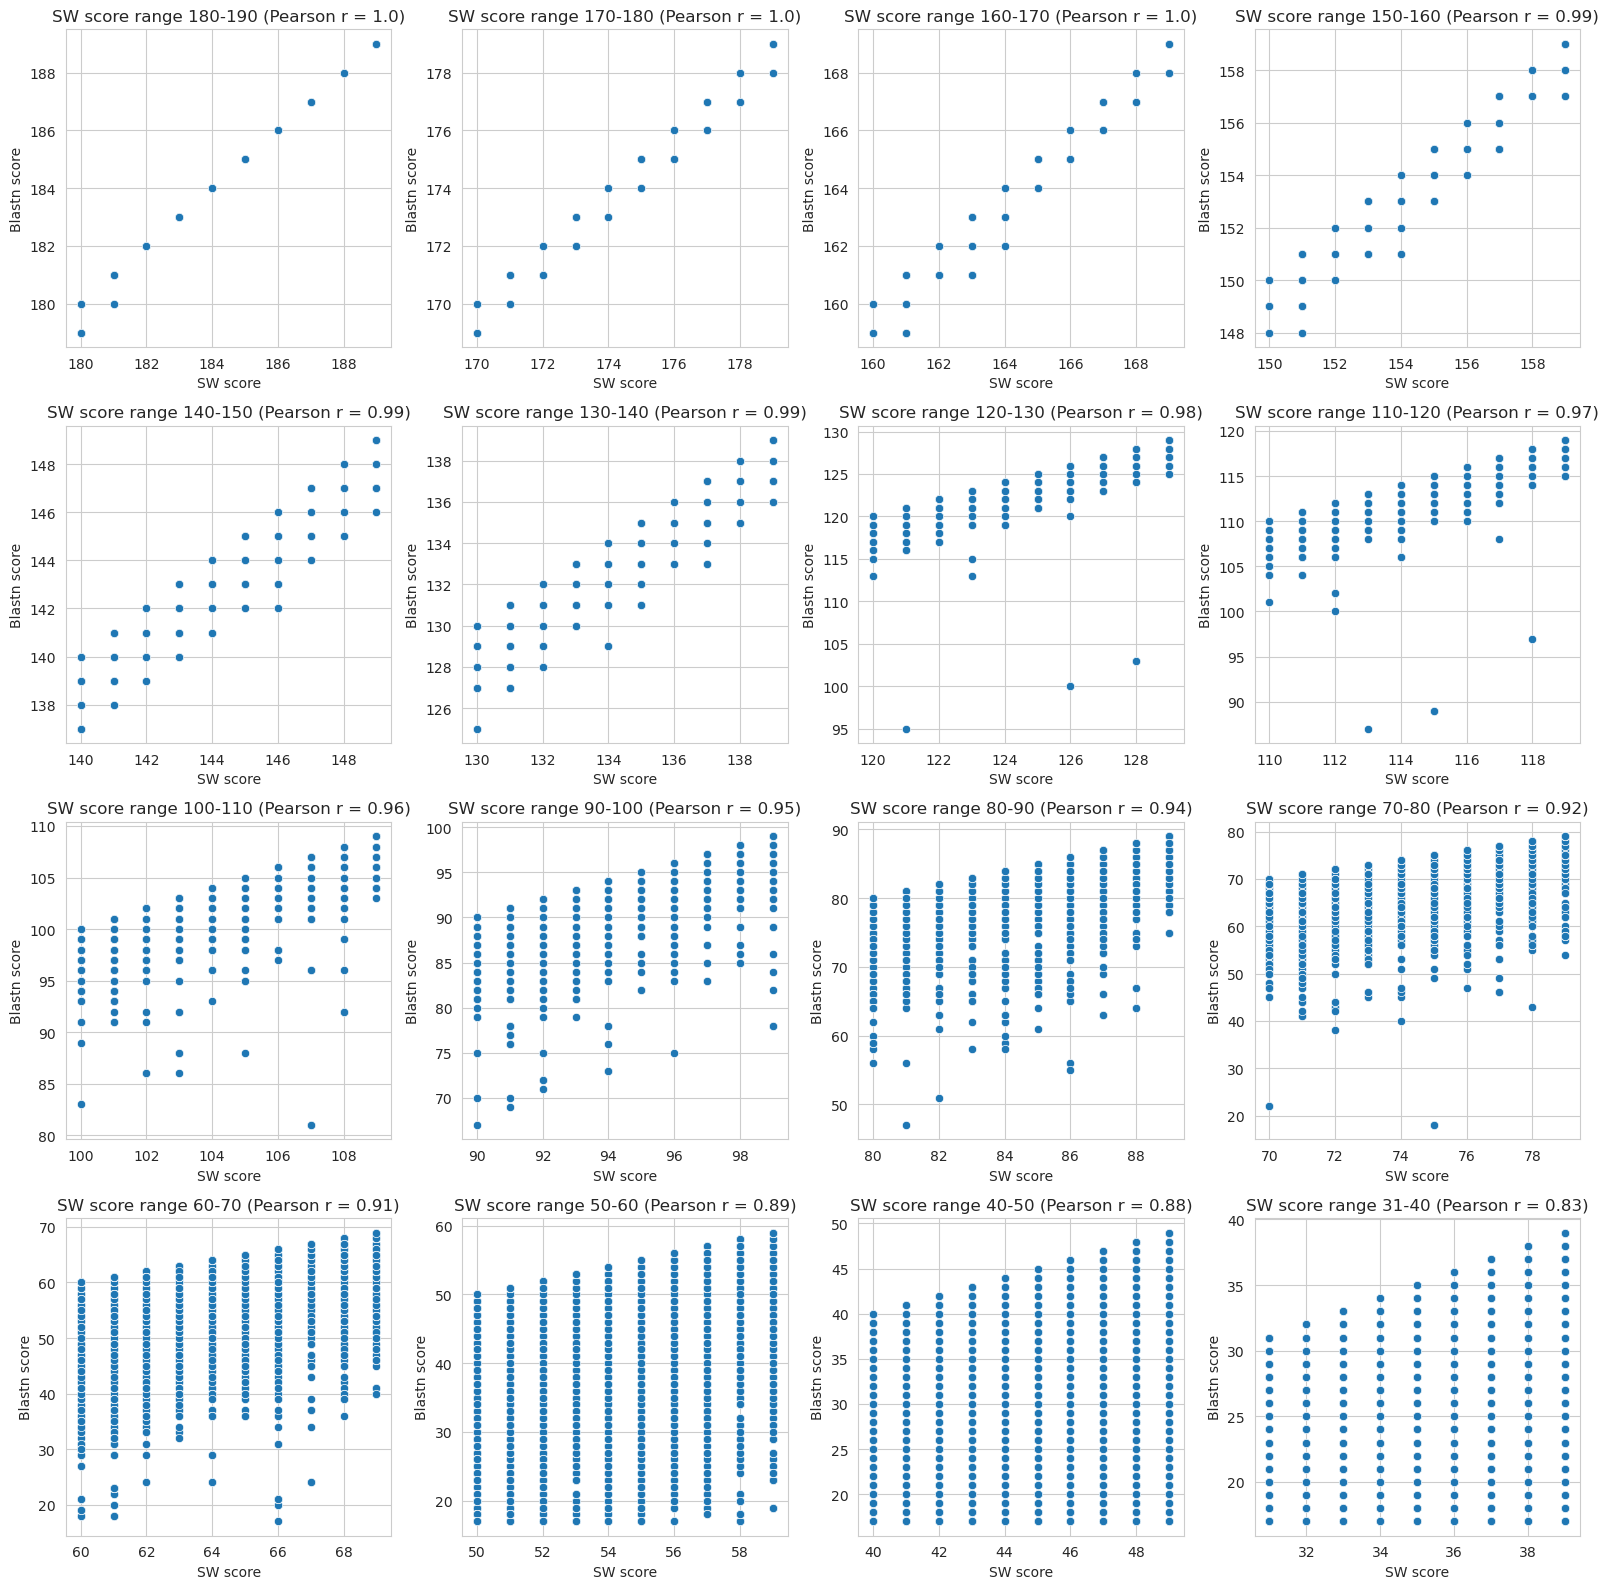

In [31]:
bounds = []
for i in range(30,190,10):
    lower_bound = i+1 if i == 30 else i
    upper_bound = i+10
    bounds.append((lower_bound,upper_bound))

sns.set_style("whitegrid")
fig,axes = plt.subplots(4,4,figsize=(16,16))
axes = np.ravel(axes)
for i,bound in enumerate(bounds[::-1]):
    subset_df = df[(df["smith_waterman_score"] >= bound[0]) & (df["smith_waterman_score"] < bound[1])]
    sns.scatterplot(subset_df,x="smith_waterman_score",y="blast_score_corrected",ax=axes[i])
    pearson = np.round(pearsonr(subset_df['smith_waterman_score'],subset_df['blast_score_corrected']).statistic,2)
    axes[i].set_title(f"SW score range {bound[0]}-{bound[1]} (Pearson r = {pearson})")
    axes[i].set_ylabel("Blastn score")
    axes[i].set_xlabel("SW score")

plt.tight_layout()
plt.show()

In [29]:
np.round(pearsonr(subset_df['smith_waterman_score'],subset_df['blast_score_corrected']).statistic,2)

0.83

# Correlation analysis word size screen

In [77]:
int(correlation_dir.split("/")[-3].split(".")[-2].split("_")[1])

7

In [9]:
results_dict = {
    "word_size":[],
    "sw_score_range":[],
    "sw_score_level":[],
    "pearson":[],
    "n":[]
}

blast_screen_dir = os.path.join(blast_dir,"K562_clean.complete.wordsize_screen")
pattern = os.path.join(blast_screen_dir,"K562_clean.complete.wordsize_*.work","K562_clean.blastn.out","correlation_analysis")
for correlation_dir in tqdm(glob(pattern)):
    w = int(correlation_dir.split("/")[-3].split(".")[-2].split("_")[1])
    pathlist = glob(os.path.join(correlation_dir,"*.sw_blast_correlation_analysis.csv.gz"))
    dfs = []
    for path in pathlist:
        dfs.append(pd.read_csv(path))
    df = pd.concat(dfs)
    for x,i in enumerate(range(0,200,10)):
        lower_bound = i+1
        upper_bound = i+10
        subset_df = df[(df["sw"] >= lower_bound) & (df["sw"] <= upper_bound)]
        if subset_df.shape[0] < 2: continue
        pearson = np.round(pearsonr(subset_df['sw'],subset_df['corrected_blast_score']).statistic,2)

        results_dict["word_size"].append(w)
        results_dict["sw_score_range"].append(f"[{lower_bound},{upper_bound}]")
        results_dict["sw_score_level"].append(x)
        results_dict["pearson"].append(pearson)
        results_dict["n"].append(subset_df.shape[0])

results_df = pd.DataFrame(results_dict)
display(results_df.head())
results_df.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:17<00:00, 32.20s/it]


,word_size,sw_score_range,sw_score_level,pearson,n
0,5,"[11,20]",1,0.74,15710846
1,5,"[21,30]",2,0.86,17876967
2,5,"[31,40]",3,0.87,8542141
3,5,"[41,50]",4,0.89,4768969
4,5,"[51,60]",5,0.90,3053948


(152, 5)

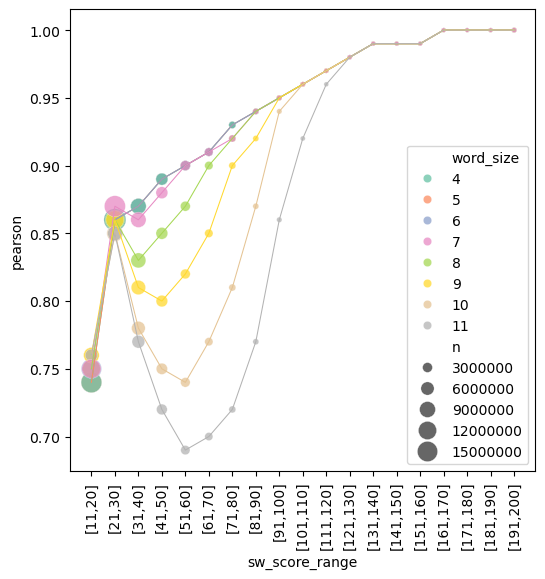

In [29]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(results_df,x="sw_score_range",y="pearson",size="n",hue="word_size",sizes=(10,250),palette="Set2",alpha=0.75,ax=ax)
sns.lineplot(results_df,x="sw_score_range",y="pearson",hue="word_size",legend=False,palette="Set2",linewidth=0.75,ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.show()

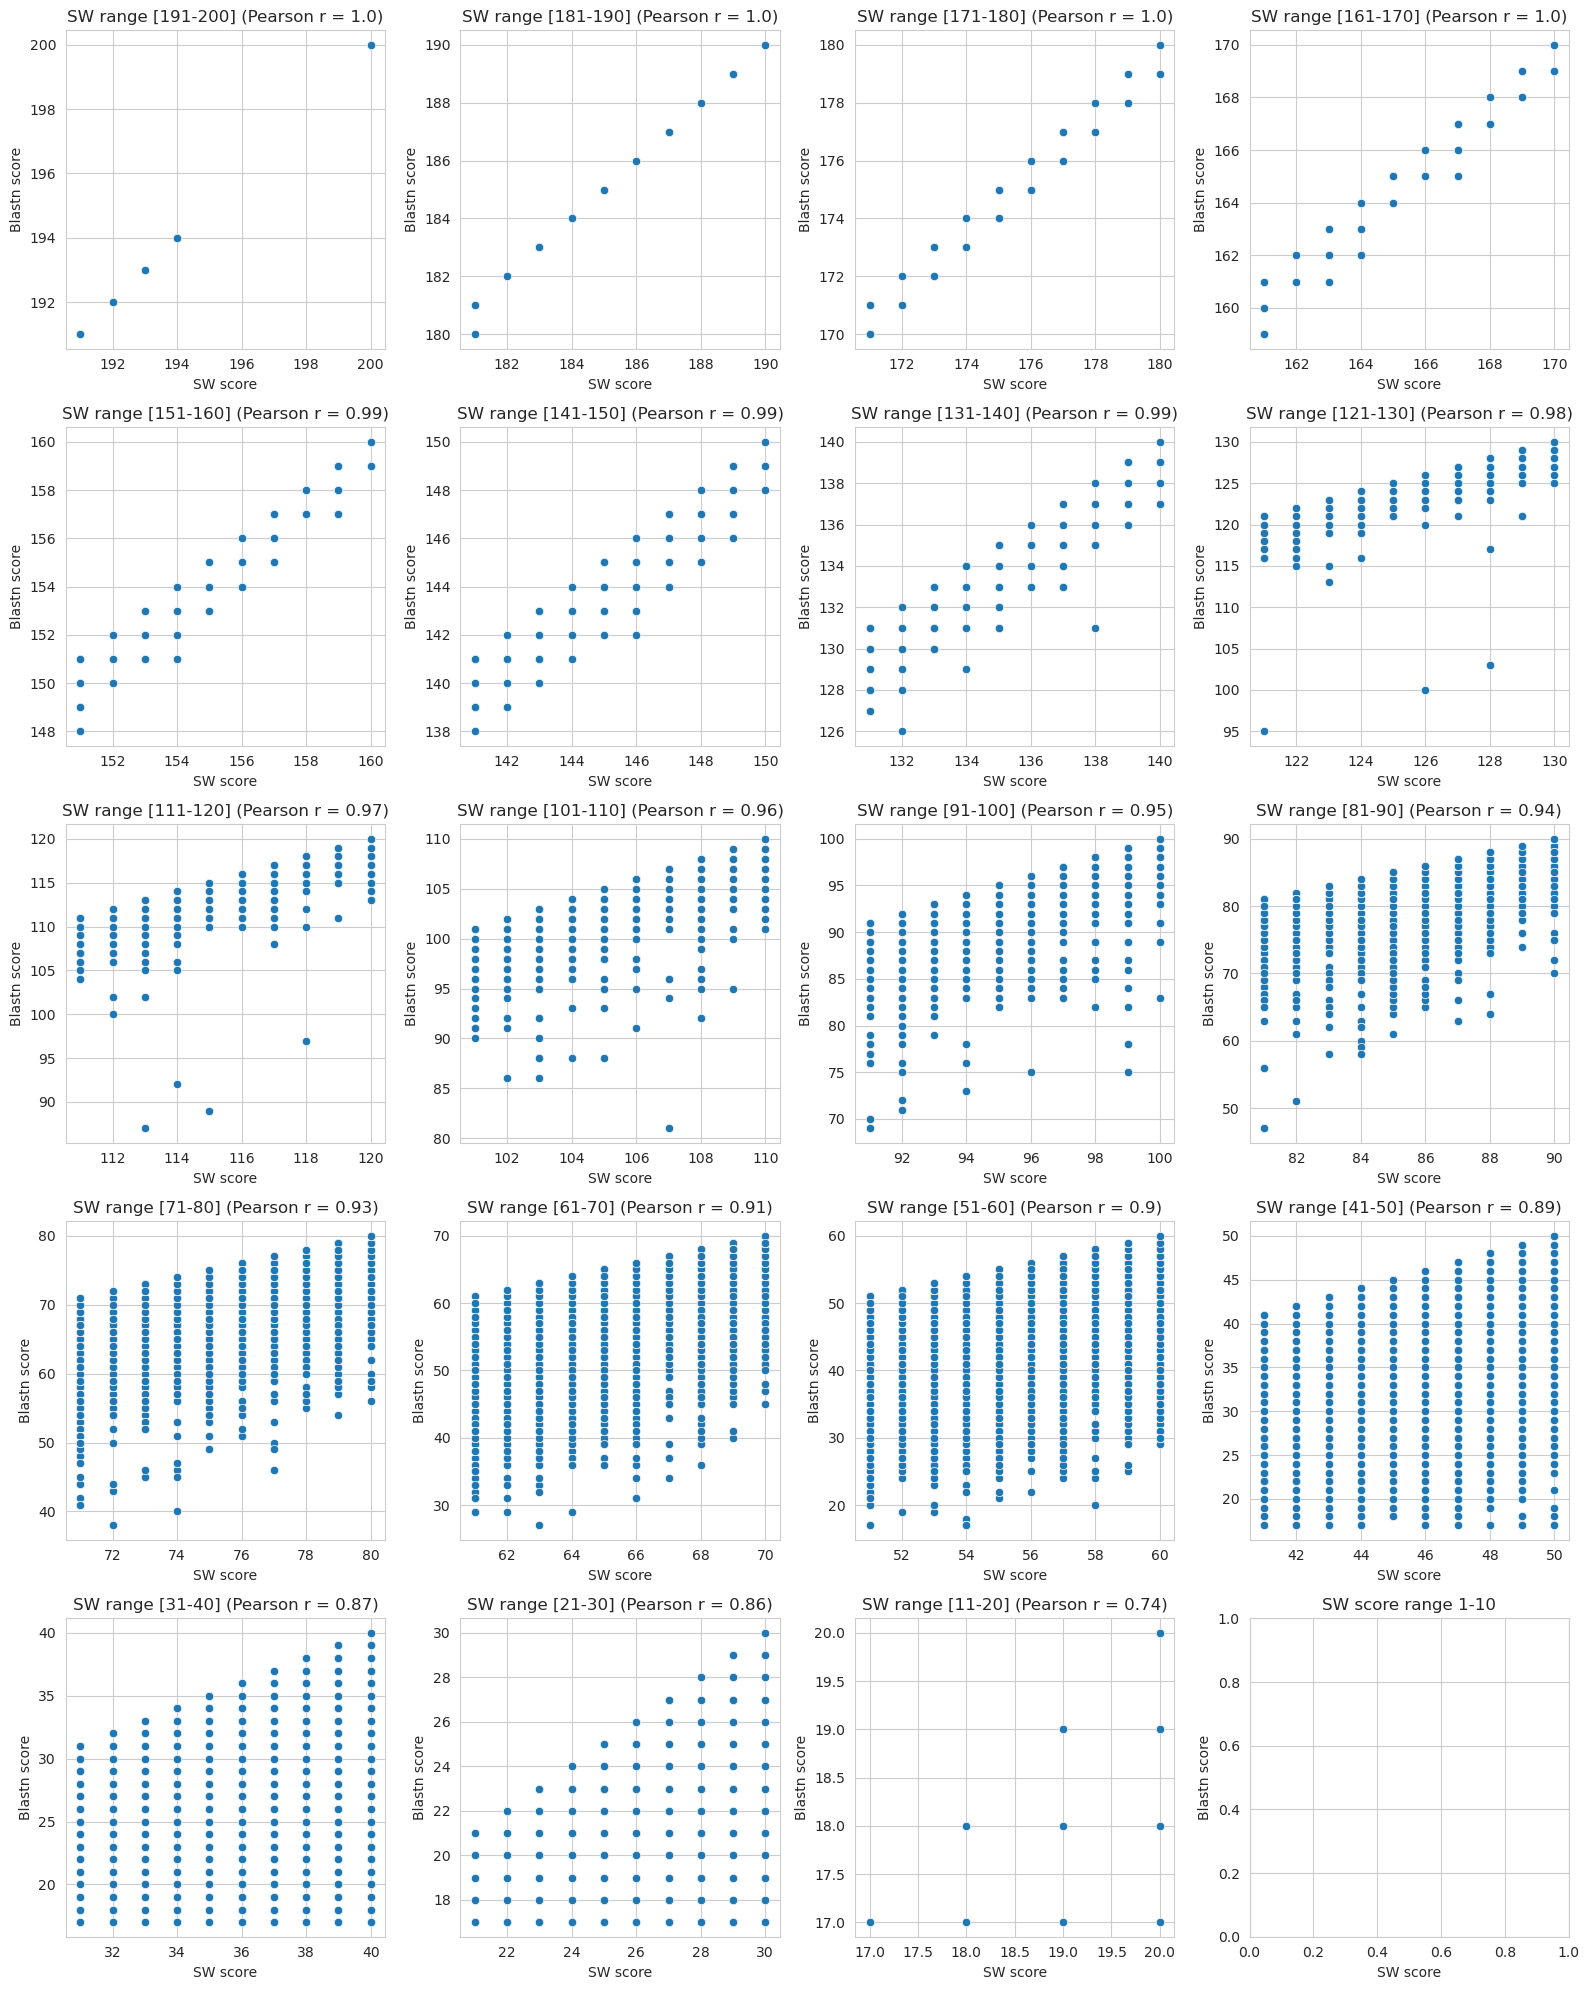

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_screen'

In [68]:
blast_screen_dir = os.path.join(blast_dir,"K562_clean.complete.wordsize_screen")
pattern = os.path.join(blast_screen_dir,"K562_clean.complete.wordsize_4.work","K562_clean.blastn.out","correlation_analysis")
for correlation_dir in glob(pattern):
    pathlist = glob(os.path.join(correlation_dir,"*.sw_blast_correlation_analysis.csv.gz"))
    dfs = []
    for path in pathlist:
        dfs.append(pd.read_csv(path))
    df = pd.concat(dfs)

    bounds = []
    for i in range(0,200,10):
        lower_bound = i+1
        upper_bound = i+10
        bounds.append((lower_bound,upper_bound))

    sns.set_style("whitegrid")
    fig,axes = plt.subplots(5,4,figsize=(16,20))
    axes = np.ravel(axes)
    for i,bound in enumerate(bounds[::-1]):
        subset_df = df[(df["sw"] >= bound[0]) & (df["sw"] <= bound[1])]
        axes[i].set_ylabel("Blastn score")
        axes[i].set_xlabel("SW score")
        if subset_df.shape[0] < 2:
            axes[i].set_title(f"SW score range {bound[0]}-{bound[1]}")
            continue
        sns.scatterplot(subset_df,x="sw",y="corrected_blast_score",ax=axes[i])
        pearson = np.round(pearsonr(subset_df['sw'],subset_df['corrected_blast_score']).statistic,2)
        axes[i].set_title(f"SW range [{bound[0]}-{bound[1]}] (Pearson r = {pearson})")

    plt.tight_layout()
    plt.show()
    break
blast_screen_dir

# Plotting BLASTn homology candidates before and after filtering by actual SW

In [4]:
blast_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast'

In [6]:
blast_columns = [
    "qseqid","sseqid","pident","length","mismatch",
    "gapopen","qstart","qend","sstart","send","evalue",
    "bitscore","score","positive","gaps"
]

candidates_dict = defaultdict(set)

before_pattern = os.path.join(blast_dir,"K562_clean.complete.wordsize_7.work","blast_partitions","K562_clean.blastn.partition_*")
for partitioned_blast_path in tqdm(sorted(glob(before_pattern))):
    if os.path.basename(partitioned_blast_path).endswith(".tsv.gz"): continue
    for chunk_df in pd.read_csv(partitioned_blast_path,names=blast_columns,sep="\t",chunksize=1_000_000):
        for query_id,candidates in chunk_df.groupby("qseqid")["sseqid"].apply(set).items():
            candidates_dict[query_id].update(candidates)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.28s/it]


In [7]:
filtered_dict = defaultdict(set)

after_pattern =  os.path.join(blast_dir,"K562_clean.complete.wordsize_7.work","blast_partitions","K562_clean.blastn.partition_*.augmented.tsv.gz")
for partitioned_blast_path in tqdm(sorted(glob(after_pattern))):
    partitioned_blast_df = pd.read_csv(partitioned_blast_path,sep="\t")
    for query_id,candidates in partitioned_blast_df.groupby("qseqid")["sseqid"].apply(set).items():
        filtered_dict[query_id].update(candidates)

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]


In [8]:
len(candidates_dict),len(filtered_dict)

(226253, 41304)

In [9]:
candidates = [len(c) for c in candidates_dict.values()]
filtered_candidates = [len(c) for c in filtered_dict.values()]

In [10]:
len(candidates),len(filtered_candidates)

(226253, 41304)

In [11]:
np.min(candidates),np.mean(candidates),np.max(candidates)

(6, 422.11358523422894, 10416)

In [12]:
np.min(filtered_candidates),np.mean(filtered_candidates),np.max(filtered_candidates)

(1, 205.7096649234941, 2052)

In [13]:
np.sum(filtered_candidates)

8496632

In [14]:
1-np.sum(filtered_candidates)/np.sum(candidates)

0.9110341909145295

In [19]:
combined_dict = {
    "seq_id":[],
    "n_candidates":[],
    "Type":[]
}

for seq_id,candidates in candidates_dict.items():
    combined_dict["seq_id"].append(seq_id)
    combined_dict["n_candidates"].append(len(candidates))
    combined_dict["Type"].append("candidates")
    
for seq_id,candidates in filtered_dict.items():
    combined_dict["seq_id"].append(seq_id)
    combined_dict["n_candidates"].append(len(candidates))
    combined_dict["Type"].append("filtered candidates (SW >= 60)")

combined_df = pd.DataFrame(combined_dict)

In [20]:
combined_df.head()

,seq_id,n_candidates,Type
0,peak10,37,candidates
1,peak1000,121,candidates
2,peak10000,170,candidates
3,peak10000_Reversed,171,candidates
4,peak10001,4671,candidates


In [21]:
outpath = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/hashFrag.blastn.n_candidates.before_after_filtering.csv.gz"
combined_df.to_csv(outpath,compression="gzip",index=False)

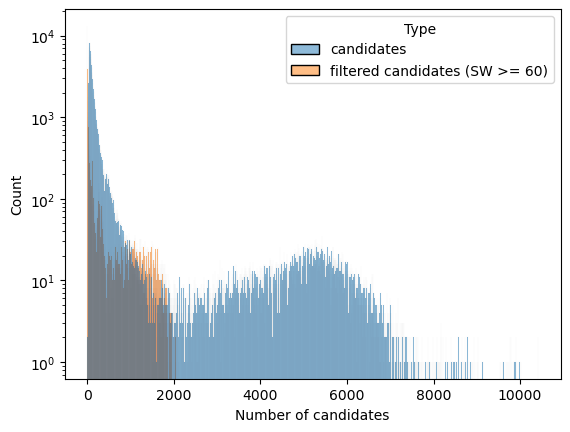

In [22]:
sns.histplot(combined_dict,x="n_candidates",hue="Type")
# plt.xscale('log')
plt.ylabel("Count")
plt.xlabel("Number of candidates")
plt.yscale('log')
plt.show()

# Collecting BLAST job runtimes for different dataset sizes and word sizes

In [27]:
fasta_path

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/dataset_sizes/K562.sample_200k.fa.gz'

In [34]:
results_dict = {
    "dataset_size":[],
    "word_size":[],
    "cpu_time":[],
    "memory":[],
    
}
qsub_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/scripts/qsub_files/blast_screen"
pattern  = os.path.join(qsub_dir,"bkHF_BLAST.o*")
for qsub_path in tqdm(glob(pattern)):
    with open(qsub_path,"r") as handle:
        content = handle.read().splitlines()
    fasta_path = content[0]
    dataset_size = int(os.path.basename(fasta_path).split(".")[1].split("_")[1].replace("k",""))*1000
    word_size = int(content[1])
    memory = int(content[-1].split(",KB")[0])
    job_id = os.path.basename(qsub_path).split("bkHF_BLAST.o")[1]
    command = f"qreport -j {job_id}"
    process = subprocess.run(command,shell=True,capture_output=True)
    for line in process.stdout.decode("utf-8").splitlines():
        if line.startswith("cpu"):
            cpu_time = float(line.split()[-1])
    results_dict["dataset_size"].append(dataset_size)
    results_dict["word_size"].append(word_size)
    results_dict["cpu_time"].append(cpu_time)
    results_dict["memory"].append(memory)

results_df = pd.DataFrame(results_dict)
results_df.head()

100%|██████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.96it/s]


,dataset_size,word_size,cpu_time,memory
0,200000,11,18018.4,20376704
1,200000,7,56769.9,10431112
2,100000,10,5750.7,3984800
3,100000,8,9707.6,3292808
4,200000,4,1414248.2,8655164


In [37]:
results_df.shape

(32, 4)

In [33]:
candidates_dict = {
    "dataset_size":[],
    "word_size":[],
    "n_candidates":[]
}
blast_pattern = os.path.join(blast_dir,"dataset_sizes","K562.sample_*.wordsize_*.blastn.work","K562.sample_*.blastn.out")
for path in tqdm(glob(blast_pattern)):
    info = os.path.basename(os.path.dirname(path)).split(".")
    dataset_size = int(info[1].split("_")[1].replace("k",""))*1000
    word_size = int(info[2].split("_")[1])
    with open(path,"r") as handle:
        n_candidates = len(handle.read().splitlines())
    candidates_dict["dataset_size"].append(dataset_size)
    candidates_dict["word_size"].append(word_size)
    candidates_dict["n_candidates"].append(n_candidates)

candidates_df = pd.DataFrame(candidates_dict)
candidates_df

100%|██████████████████████████████████████████████████| 32/32 [08:29<00:00, 15.92s/it]


,dataset_size,word_size,n_candidates
0,100000,7,23825283
1,150000,5,59346841
2,100000,11,12327430
3,50000,6,10745994
4,200000,4,105970469
5,150000,8,46859697
6,200000,5,105673199
7,150000,9,40020745
8,150000,4,59515436
9,200000,9,71332247


In [36]:
runtime_df = pd.merge(results_df,candidates_df,left_on=["dataset_size","word_size"],right_on=["dataset_size","word_size"],how="left")
display(runtime_df.head())
runtime_df.shape

,dataset_size,word_size,cpu_time,memory,n_candidates
0,200000,11,18018.4,20376704,49257417
1,200000,7,56769.9,10431112,95369046
2,100000,10,5750.7,3984800,14901402
3,100000,8,9707.6,3292808,20868885
4,200000,4,1414248.2,8655164,105970469


(32, 5)

In [38]:
runtime_path = os.path.join(analysis_dir,"blast_screen.runtime_analysis.csv")
runtime_df.to_csv(runtime_path,index=False)

In [39]:
runtime_path

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/blast_screen.runtime_analysis.csv'

# Filter BLASTn results

In [4]:
def load_fasta_as_dictionary(path):
    fasta_dict = {}
    with gzip.open(path,"rt") as handle:
        for record in tqdm(SeqIO.parse(handle,"fasta")):
            fasta_dict[record.id] = str(record.seq)
    return fasta_dict

def get_complementary_id(seq_id):
    if seq_id.endswith("_Reversed"): # reverse strand
        return seq_id.replace("_Reversed","")
    else: # forward strand
        return seq_id+"_Reversed"

In [5]:
%%time

fasta_dict = load_fasta_as_dictionary(fasta_path)
ids = list(fasta_dict)
idset = set(ids)
N = len(ids)
print(f"{N} total sequences")

226253it [00:01, 171289.17it/s]

226253 total sequences
CPU times: user 1.21 s, sys: 55.9 ms, total: 1.26 s
Wall time: 3.04 s


In [6]:
filtered_idset = set()
for seq_id in tqdm(ids):
    complementary_id = get_complementary_id(seq_id)
    if complementary_id in idset:
        filtered_idset.add(seq_id)
        filtered_idset.add(complementary_id)

len(filtered_idset)

100%|███████████████████████████████████| 226253/226253 [00:00<00:00, 1486308.61it/s]


223052

In [7]:
# path = os.path.join(sw_dir,"K562_clean.pairwise_comparisons.compiled.filter30.txt.gz")
# df = pd.read_csv(path,compression="gzip")
# df = df[(df["sw"] >= 60) & (df["candidate"] == 1) & (df["id_i"] != df["id_j"]) & (df["id_i"].isin(filtered_idset)) & (df["id_j"].isin(filtered_idset))]
# display(df.head())
# df.shape

In [9]:
# unique_set  = set()
# redundant_list = []
# for _,row in tqdm(df.iterrows()):
#     id_i = row["id_i"]
#     id_j = row["id_j"]
#     redundant_list.append((id_i,id_j) in unique_set)
#     unique_set.update([(id_i,id_j),(id_j,id_i)])

In [50]:
# np.sum(redundant_list)
# df["redundant"] = redundant_list
# df = df[~df["redundant"]]
# df.shape

(4248316, 5)

# NOTE: THIS IS USING HEURISTIC BLAST SCORE!!! (DON'T FORGET TO CHANGE BACK)

In [8]:
filtered_blast_path = os.path.join(blast_dir,"blastn_results.corrected_blast_score.filtered_candidates.tsv.gz") # os.path.join(blast_dir,"blastn_results.filtered_candidates.tsv.gz")
filtered_blast_df = pd.read_csv(filtered_blast_path,sep="\t")
display(filtered_blast_df.head())
filtered_blast_df.shape

,qseqid,sseqid,blast_score_corrected,pair
0,peak10,peak10,200,"('peak10', 'peak10')"
1,peak10,peak64621_Reversed,161,"('peak10', 'peak64621_Reversed')"
2,peak10,peak33267,138,"('peak10', 'peak33267')"
3,peak10_Reversed,peak10_Reversed,200,"('peak10_Reversed', 'peak10_Reversed')"
4,peak10_Reversed,peak64621,161,"('peak10_Reversed', 'peak64621')"


(4616010, 4)

In [9]:
len(filtered_idset)

223052

In [10]:
filtered_candidates_dict = defaultdict(set)
for _,row in tqdm(filtered_blast_df.iterrows()):
    # id_i,id_j = row["pair"].replace("(","").replace(")","").replace("'","").split(", ")
    id_i = row["qseqid"]
    id_j = row["sseqid"]
    if id_i not in filtered_idset or id_j not in filtered_idset: continue
    filtered_candidates_dict[id_i].add(id_j)
    filtered_candidates_dict[id_j].add(id_i)


4616010it [02:34, 29806.41it/s]


In [11]:
np.sum([len(g) for g in filtered_candidates_dict.values()]),len(filtered_candidates_dict)

(8321192, 223052)

In [12]:
np.sum([len(g) for g in filtered_candidates_dict.values()]),len(filtered_candidates_dict)

(8321192, 223052)

In [13]:
symmetric_candidates_dict = defaultdict(set)
for query_id,candidates in tqdm(filtered_candidates_dict.items()):
    symmetric_candidates_dict[query_id].add(query_id) # adding itself

    query_id_ = get_complementary_id(query_id)
    assert query_id_ in filtered_idset

    symmetric_candidates_dict[query_id].add(query_id_)
    symmetric_candidates_dict[query_id_].add(query_id)

    for subject_id in candidates:
        subject_id_ = get_complementary_id(subject_id)
        assert subject_id_ in filtered_idset

        symmetric_candidates_dict[query_id].add(subject_id)
        symmetric_candidates_dict[query_id].add(subject_id_)

        symmetric_candidates_dict[query_id_].add(subject_id)
        symmetric_candidates_dict[query_id_].add(subject_id_)

n_before = len(symmetric_candidates_dict)

to_delete = set()
for query_id,candidates in symmetric_candidates_dict.items():
    if len(candidates) == 2:
        assert set([query_id,get_complementary_id(query_id)]) == candidates
        to_delete.update(candidates)
to_delete = list(to_delete)
for query_id in to_delete:
    del symmetric_candidates_dict[query_id]

print(f"Removing trivial cases: {n_before}-{len(to_delete)}={len(symmetric_candidates_dict)} entries remaining.")

100%|█████████████████████████████████████| 223052/223052 [00:09<00:00, 24657.83it/s]


Removing trivial cases: 223052-182432=40620 entries remaining.


In [14]:
candidate_idset = set()
for query_id,candidates in symmetric_candidates_dict.items():
    candidate_idset.add(query_id)
    candidate_idset.update(candidates)
assert candidate_idset.issubset(filtered_idset)

candidate_ids = list(candidate_idset)

n = len(candidate_ids)
id_map = {seq_id:i for i,seq_id in enumerate(candidate_ids)}

print(n)

40620


In [13]:
# symmetry check

for query_id,candidates in symmetric_candidates_dict.items():
    assert candidates == symmetric_candidates_dict[get_complementary_id(query_id)]

In [15]:
import random
import igraph as ig
# import scipy.sparse as sp
from scipy.sparse import coo_matrix,csr_matrix
from collections import defaultdict

In [16]:
row = []
col = []
data = []

# Collect edges in batches
for id_i,candidates in tqdm(symmetric_candidates_dict.items()):
    i = id_map[id_i]
    for id_j in candidates:
        j = id_map[id_j]
        row.append(i)
        col.append(j)
        data.append(1)  # Edge weight (using 1 for unweighted graph)

# Create the sparse matrix in one step using COO format
sparse_mat = coo_matrix((data,(row,col)),shape=(n, n)).tocsr()

100%|████████████████████████████████████████| 40620/40620 [00:04<00:00, 9702.90it/s]


In [17]:
g = ig.Graph.Weighted_Adjacency(
    matrix=sparse_mat,
    mode="undirected",
    loops=False,
    attr="candidates"
)

In [18]:
components = g.connected_components(mode='weak')
similar_groups = []
for component in components:
    similar_groups.append({ candidate_ids[i] for i in component })
len(similar_groups)

1827

In [19]:
for i,group_i in enumerate(similar_groups):
    for j,group_j in enumerate(similar_groups):
        if i == j: continue
        assert group_i.isdisjoint(group_j)

In [33]:
# fig, ax = plt.subplots()
# ig.plot(
#     components,
#     target=ax,
#     palette=ig.RainbowPalette(),
#     vertex_size=0.1,
#     vertex_color=list(map(int,ig.rescale(components.membership,(0,200),clamp=True))),
#     edge_width=0.1
# )
# plt.show()

In [20]:
orthogonal_idset = filtered_idset.difference(candidate_idset)
print(len(filtered_idset),len(candidate_idset),len(orthogonal_idset),len(candidate_idset)+len(orthogonal_idset))

filtered_ids   = list(filtered_idset)
candidate_ids  = list(candidate_idset)
orthogonal_ids = list(orthogonal_idset)

223052 40620 182432 223052


## splits

In [21]:
chrom_path = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/id_chrom.csv"
chrom_df = pd.read_csv(chrom_path)
chrom_df.head()

chrom_dict = {}
for idx,row in chrom_df.iterrows():
    chrom_dict[row["id"]] = row["chrom"]

## hashFrag train and val

In [219]:
# random.seed(21)

# train_size = 80_000
# val_size   = 20_000

# homology_visited = set()

# for i in tqdm(range(100)):
#     split = f"split_{i+1:0>3}"

#     train_split = set()
#     while len(train_split) < train_size:
#         seq_id = random.choice(filtered_ids)
#         seq_id_ = get_complementary_id(seq_id)
#         if (seq_id in train_split) or (seq_id in homology_visited): continue

#         train_split.add(seq_id)
#         train_split.add(seq_id_)
#         if len(train_split) == train_size: break

#         if seq_id in candidate_idset:
#             for similar_group in similar_groups:
#                 if seq_id not in similar_group: continue
#                 assert seq_id not in homology_visited
#                 homology_visited.update(similar_group)
#                 for similar_id in similar_group:
#                     similar_id_ = get_complementary_id(similar_id)
#                     train_split.add(similar_id)
#                     train_split.add(similar_id_)
#                     if len(train_split) == train_size: break

#     assert len(train_split) == train_size
#     for seq_id in train_split:
#         assert get_complementary_id(seq_id) in train_split

#     val_split = set()
#     while len(val_split) < val_size:
#         seq_id = random.choice(filtered_ids)
#         seq_id_ = get_complementary_id(seq_id)
#         if (seq_id in train_split) or (seq_id in homology_visited) or (seq_id in val_split): continue

#         val_split.add(seq_id)
#         val_split.add(seq_id_)
#         if len(val_split) == val_size: break

#         if seq_id in candidate_idset:
#             for similar_group in similar_groups:
#                 if seq_id not in similar_group: continue
#                 assert seq_id not in homology_visited
#                 homology_visited.update(similar_group)
#                 for similar_id in similar_group:
#                     similar_id_ = get_complementary_id(similar_id)
#                     val_split.add(similar_id)
#                     val_split.add(similar_id_)
#                     if len(val_split) == val_size: break

#     assert len(val_split) == val_size
#     for seq_id in val_split:
#         assert get_complementary_id(seq_id) in val_split
#     assert val_split.isdisjoint(train_split)

#     train_split = sorted(train_split)
#     val_split = sorted(val_split)
#     outpath = os.path.join(split_dir,f"homology_train{len(train_split)}.homology_val{len(val_split)}.hashFrag.{split}.csv.gz")
#     with gzip.open(outpath,"wt") as handle:
#         handle.write("id,split,chrom\n")
#         for seq_id in train_split:
#             chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
#             handle.write(f"{seq_id},train,{chrom}\n")
#         for seq_id in val_split:
#             chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
#             handle.write(f"{seq_id},val,{chrom}\n")


100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


## homology can only occurin train split

In [220]:
# random.seed(21)

# train_size = 80_000
# val_size   = 20_000

# homology_visited = set()

# for i in tqdm(range(100)):
#     split = f"split_{i+1:0>3}"

#     val_split = set()
#     while len(val_split) < val_size:
#         seq_id = random.choice(orthogonal_ids) # only sampling from orthogonal sequences!!!
#         seq_id_ = get_complementary_id(seq_id)
#         if (seq_id in homology_visited) or (seq_id in val_split): continue

#         val_split.add(seq_id)
#         val_split.add(seq_id_)
#         if len(val_split) == val_size: break

#         assert seq_id not in candidate_idset

#     train_split = set()
#     while len(train_split) < train_size:
#         seq_id = random.choice(filtered_ids)
#         seq_id_ = get_complementary_id(seq_id)
#         if (seq_id in val_split) or (seq_id in train_split) or (seq_id in homology_visited): continue

#         train_split.add(seq_id)
#         train_split.add(seq_id_)
#         if len(train_split) == train_size: break

#         if seq_id in candidate_idset:
#             for similar_group in similar_groups:
#                 if seq_id not in similar_group: continue
#                 assert seq_id not in homology_visited
#                 homology_visited.update(similar_group)
#                 for similar_id in similar_group:
#                     similar_id_ = get_complementary_id(similar_id)
#                     train_split.add(similar_id)
#                     train_split.add(similar_id_)
#                     if len(train_split) == train_size: break

#     assert len(train_split) == train_size
#     for seq_id in train_split:
#         assert get_complementary_id(seq_id) in train_split

#     assert len(val_split) == val_size
#     for seq_id in val_split:
#         assert get_complementary_id(seq_id) in val_split
#     assert val_split.isdisjoint(train_split)

#     train_split = sorted(train_split)
#     val_split = sorted(val_split)
#     outpath = os.path.join(split_dir,f"homology_train{len(train_split)}.orthogonal_val{len(val_split)}.hashFrag.{split}.csv.gz")
#     with gzip.open(outpath,"wt") as handle:
#         handle.write("id,split,chrom\n")
#         for seq_id in train_split:
#             chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
#             handle.write(f"{seq_id},train,{chrom}\n")
#         for seq_id in val_split:
#             chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
#             handle.write(f"{seq_id},val,{chrom}\n")


100%|██████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


In [36]:
len(filtered_ids)

223052

## Splitting the complete dataset by proportion

In [20]:
M = len(filtered_ids)
p_train = 0.8
p_val = 0.2
train_size = int(round(M*p_train,0))
val_size   = int(round(M*p_val,0))
train_size,val_size

(178442, 44610)

In [24]:
random.seed(21)

for i in tqdm(range(10)):
    split = f"split_{i+1:0>3}"

    filtered_ids_ = filtered_ids.copy()
    homology_visited = set()

    train_split = set()
    while len(train_split) < train_size:
        seq_id = random.choice(filtered_ids_)
        seq_id_ = get_complementary_id(seq_id)
        if (seq_id in train_split) or (seq_id in homology_visited): continue

        train_split.add(seq_id)
        train_split.add(seq_id_)
        filtered_ids_.remove(seq_id)
        filtered_ids_.remove(seq_id_)

        if seq_id in candidate_idset:
            for similar_group in similar_groups:
                if seq_id not in similar_group: continue
                assert seq_id not in homology_visited
                homology_visited.update(similar_group)
                filtered_ids_ = list(set(filtered_ids_).difference(set(similar_group)))
                for similar_id in similar_group:
                    similar_id_ = get_complementary_id(similar_id)
                    train_split.add(similar_id)
                    train_split.add(similar_id_)

    for seq_id in train_split:
        assert get_complementary_id(seq_id) in train_split

    val_split = set(filtered_ids_)

    for seq_id in val_split:
        assert get_complementary_id(seq_id) in val_split
    assert val_split.isdisjoint(train_split)

    train_split = sorted(train_split)
    val_split = sorted(val_split)
    outpath = os.path.join(split_dir,f"homology_train{len(train_split)}.homology_val{len(val_split)}.hashFrag_corrected_blast_score.complete.{split}.csv.gz")
    # print(outpath)
    with gzip.open(outpath,"wt") as handle:
        handle.write("id,split,chrom\n")
        for seq_id in train_split:
            chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
            handle.write(f"{seq_id},train,{chrom}\n")
        for seq_id in val_split:
            chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
            handle.write(f"{seq_id},val,{chrom}\n")


100%|████████████████████████████████████████████████| 10/10 [26:58<00:00, 161.88s/it]


In [23]:
split_dir

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/splits'

In [18]:
train_size = 80_000
val_size = 20_000

processed_split_dir = os.path.join(split_dir,"hashFrag_blast_splits_20241206")

pattern_i = os.path.join(processed_split_dir,"homology_train178442.homology_val44610.hashFrag.complete.split_*.csv.gz")
pattern_j = os.path.join(processed_split_dir,"heuristic_homology_train178442.heuristic_homology_val44610.hashFrag.complete.split_*.csv.gz")

pathlist = sorted(glob(pattern_i)+glob(pattern_j))

for path in tqdm(pathlist):
    split = os.path.basename(path).split(".")[-3]
    df = pd.read_csv(path,compression="gzip")
    train_split = list(df[df["split"] == "train"]["id"])
    val_split = list(df[df["split"] == "val"]["id"])

    random.shuffle(train_split)
    random.shuffle(val_split)

    downsampled_train_split = []
    while len(downsampled_train_split) < train_size:
        sample_id = train_split.pop()
        sample_id_ = get_complementary_id(sample_id)
        train_split.remove(sample_id_)
        downsampled_train_split.append(sample_id)
        downsampled_train_split.append(sample_id_)

    assert len(downsampled_train_split) == train_size

    downsampled_val_split = []
    while len(downsampled_val_split) < val_size:
        sample_id = val_split.pop()
        sample_id_ = get_complementary_id(sample_id)
        val_split.remove(sample_id_)
        downsampled_val_split.append(sample_id)
        downsampled_val_split.append(sample_id_)

    assert len(downsampled_val_split) == val_size

    downsampled_train_set = set(downsampled_train_split)
    for seq_id in downsampled_train_split:
        assert get_complementary_id(seq_id) in downsampled_train_set

    downsampled_val_set = set(downsampled_val_split)
    for seq_id in downsampled_val_split:
        assert get_complementary_id(seq_id) in downsampled_val_set
    assert downsampled_val_set.isdisjoint(downsampled_train_set)

    outpath = path.replace("complete","subsampled").replace("train178442","train80000").replace("val44610","val20000")
    # print(outpath)
    with gzip.open(outpath,"wt") as handle:
        handle.write("id,split,chrom\n")
        for seq_id in downsampled_train_split:
            chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
            handle.write(f"{seq_id},train,{chrom}\n")
        for seq_id in downsampled_val_split:
            chrom = chrom_dict[seq_id] if seq_id in chrom_dict else 'NaN'
            handle.write(f"{seq_id},val,{chrom}\n")

100%|████████████████████████████████████████████████████| 40/40 [32:21<00:00, 48.54s/it]


In [17]:
path.replace("complete","subsampled").replace("train178442","train80000").replace("val44610","val20000")

'/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/splits/hashFrag_blast_splits_20241206/heuristic_homology_train80000.heuristic_homology_val20000.hashFrag.subsampled.split_001.csv.gz'

In [49]:
for path in tqdm(glob(os.path.join(split_dir,"homology_train178442.homology_val44610.hashFrag.complete.split_*.csv.gz"))):
    df = pd.read_csv(path,compression="gzip")
    train_split = set(df[df["split"] == "train"]["id"])
    val_split = set(df[df["split"] == "val"]["id"])
    flag = False
    for seq_id in train_split:
        if seq_id in candidate_idset:
            for seq_id_ in symmetric_candidates_dict[seq_id]:
                # assert seq_id_ not in val_split
                if seq_id_ in val_split:
                    flag = True
    for seq_id in val_split:
        if seq_id in candidate_idset:
            for seq_id_ in symmetric_candidates_dict[seq_id]:
                # assert seq_id_ not in val_split
                if seq_id_ in train_split:
                    flag = True
    if flag:
        print(os.path.basename(path),"leakage")

100%|████████████████████████████████████████████████████| 30/30 [01:08<00:00,  2.29s/it]


In [43]:
# for path in tqdm(glob(os.path.join(split_dir,"homology_train178442.homology_val44610.hashFrag.complete.split_*.csv.gz"))):
#     df = pd.read_csv(path,compression="gzip")
#     train_split = set(df[df["split"] == "train"]["id"])
#     val_split   = set(df[df["split"] == "val"]["id"])

#     flag = False
#     for seq_id in train_split:
#         if seq_id in candidate_idset:
#             for seq_id_ in symmetric_candidates_dict[seq_id]:
#                 if seq_id_ in val_split:
#                     flag = True
#     for seq_id in val_split:
#         if seq_id in candidate_idset:
#             for seq_id_ in symmetric_candidates_dict[seq_id]:
#                 if seq_id_ in train_split:
#                     flag = True
#     if flag:
#         print(os.path.basename(path),"leakage")

In [25]:
train_splits = []
val_splits = []
for path in tqdm(glob(os.path.join(split_dir,"hashFrag.corrected_blast_splits.created_20241213","*.csv.gz"))):
    df = pd.read_csv(path,compression="gzip")
    train_split = set(df[df["split"] == "train"]["id"])
    val_split   = set(df[df["split"] == "val"]["id"])
    train_splits.append(train_split)
    val_splits.append(val_split)

100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]


In [28]:
jaccards = []
for i,t_i in tqdm(enumerate(val_splits)):
    for j,t_j in enumerate(val_splits):
        if i == j: continue
        jaccards.append(len(t_i & t_j) / len(t_i | t_j))

10it [00:00, 20.74it/s]


<AxesSubplot: ylabel='Count'>

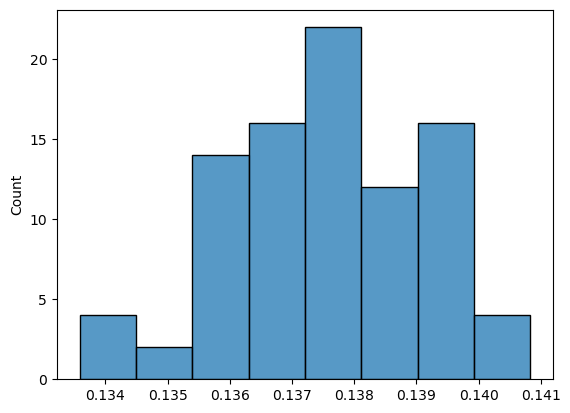

In [29]:
sns.histplot(jaccards)

In [50]:
count = 0
for seq in train_split:
    if seq in candidate_idset:
        count += 1
print(count)

count = 0
for seq in val_split:
    if seq in candidate_idset:
        count += 1
print(count)

41028
266


In [51]:
266/41028,len(val_split)/len(train_split)

(0.006483377205810666, 0.249997197969088)

In [223]:
for path in tqdm(glob(os.path.join(split_dir,"*.csv.gz"))):
    df = pd.read_csv(path,compression="gzip")
    train_split = set(df[df["split"] == "train"]["id"])
    val_split = set(df[df["split"] == "val"]["id"])
    flag = False
    for seq_id in train_split:
        if seq_id in candidate_idset:
            for seq_id_ in symmetric_candidates_dict[seq_id]:
                # assert seq_id_ not in val_split
                if seq_id_ in val_split:
                    flag = True
    for seq_id in val_split:
        if seq_id in candidate_idset:
            for seq_id_ in symmetric_candidates_dict[seq_id]:
                # assert seq_id_ not in val_split
                if seq_id_ in train_split:
                    flag = True
    if flag:
        print(os.path.basename(path),"leakage")

100%|██████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.02it/s]


In [215]:
len(train_split),len(homology_visited),len(val_split)

(80000, 38422, 20000)

# Creating 50/50 chromosomal split for BLAST analysis to investigate Xdrop threshold parameters (extension heuristic cutoff)

In [2]:
chrom_path = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/id_chrom.csv"

In [3]:
chrom_df = pd.read_csv(chrom_path)
chrom_df

,id,chrom
0,peak10,chr1
1,peak10_Reversed,chr1
2,peak1000,chr1
3,peak1000_Reversed,chr1
4,peak10000,chr1
...,...,...
225943,RBM38_9948_Reversed,chr20
225944,RBM38_9951,chr20
225945,RBM38_9951_Reversed,chr20
225946,RBM38_9952,chr20


In [7]:
chrom_dict = defaultdict(list)
for seq_id,chrom in zip(chrom_df["id"],chrom_df["chrom"]):
    chrom_dict[chrom].append(seq_id)
chroms = list(chrom_dict)

In [8]:
n_splits = 10
sample_size = 30_000

In [9]:
out_dir = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/chrom_split"

In [15]:
def get_reverse_complement_id(seq_id):
    if seq_id.endswith("_Reversed"):
        return seq_id.replace("_Reversed","")
    else:
        return seq_id+"_Reversed"

In [20]:
for chrom,ids in chrom_dict.items():
    print(chrom,len(ids))

chr1 22437
chr10 9139
chr11 18186
chr12 9676
chr13 3424
chr14 5236
chr15 6341
chr16 10807
chr17 9216
chr18 3434
chr19 8132
chr2 19207
chr20 9442
chr21 2705
chr22 4291
chr3 11973
chr4 8567
chr5 9143
chr6 13505
chr7 11189
chr8 12513
chr9 7587
chrX 9749
chrY 49


In [22]:
for chrom,ids in chrom_dict.items():
    outpath = os.path.join(out_dir,f"{chrom}.txt.gz")
    with gzip.open(outpath,"wt") as handle:
        handle.write("\n".join(sorted(ids))+"\n")

In [25]:
fasta_path = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/K562_clean.fa.gz"
fasta_dict = {}
with gzip.open(fasta_path,"rt") as handle:
    for record in SeqIO.parse(handle,"fasta"):
        fasta_dict[record.id] = str(record.seq)

In [26]:
pattern = os.path.join(out_dir,"chr*.txt.gz")
for chrom,ids in chrom_dict.items():
    outpath = os.path.join(out_dir,f"{chrom}.fa.gz")
    with gzip.open(outpath,"wt") as handle:
        for seq_id in sorted(ids):
            handle.write(f">{seq_id}\n{fasta_dict[seq_id]}\n")

In [39]:
from pandas.errors import EmptyDataError

In [50]:
pattern = "/home/brett/work/FRACTAL2_development/development/biased_subsampling/demonstrations/datasets/czi_datasets/h5ads_integrated_embeddings/czi.version_20240701.embedding_geneformer.batch_*.csv.gz"

empty_files = []
for path in tqdm(glob(pattern)):
    try:
        for chunk_df in pd.read_csv(path,header=None,index_col=0,chunksize=10):
            break
    except EmptyDataError:
        empty_files.append(path)

KeyboardInterrupt: 

In [53]:
process

CompletedProcess(args='ls -thor czi.version_20240701.embedding_geneformer.batch_*.csv.gz', returncode=2, stdout=b'', stderr=b"ls: cannot access 'czi.version_20240701.embedding_geneformer.batch_*.csv.gz': No such file or directory\n")

In [59]:
empty_files = []

input_dir = "/home/brett/work/FRACTAL2_development/development/biased_subsampling/demonstrations/datasets/czi_datasets/h5ads_integrated_embeddings"
command = f"ls -thor {input_dir}/czi.version_20240701.embedding_geneformer.batch_*.csv.gz"
process = subprocess.run(command,shell=True,capture_output=True)
if process.returncode != 0:
    raise Exception
else:
    for line in process.stdout.decode("utf-8").strip().split("\n"):
        info = line.split()
        if info[3] == '81':
            empty_files.append(info[-1])

In [61]:
for path in empty_files:
    os.remove(path)

# Generate graph visualization inputs

In [4]:
fasta_path = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/fastas/K562_clean.fa.gz"
augmented_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/blast_partitions"
out_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/graph_visualization"

In [5]:
ids = []
with gzip.open(fasta_path,"rt") as handle:
    for record in SeqIO.parse(handle,"fasta"):
        ids.append(record.id)

In [13]:
vertices_df = pd.DataFrame({"Id":ids})
vertices_df.head()

,Id
0,peak10
1,peak10_Reversed
2,peak1000
3,peak1000_Reversed
4,peak10000


In [14]:
vertices_path = os.path.join(out_dir,"vertices.csv")
vertices_df.to_csv(vertices_path,index=False)

In [11]:
pattern = os.path.join(augmented_dir,"*.augmented.tsv.gz")
edges_dict = {"Source":[],"Target":[]}
for path in tqdm(glob(pattern)):
    df = pd.read_csv(path,sep="\t")
    df = df[df["smith_waterman_score"] >= 60]
    for id_i,id_j in zip(df["qseqid"],df["sseqid"]):
        edges_dict["Target"].append(id_i)
        edges_dict["Source"].append(id_j)
edges_df = pd.DataFrame(edges_dict)
edges_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.76s/it]


,Source,Target
0,peak58995,peak3423
1,peak56908_Reversed,peak3423
2,peak49029,peak3423
3,peak34192_Reversed,peak3423
4,peak75602_Reversed,peak3423


In [15]:
edges_df.shape

(10192795, 2)

In [16]:
edges_df['pair'] = edges_df[['Source','Target']].apply(lambda x: tuple(sorted(x)),axis=1)
edges_df = edges_df.drop_duplicates(subset='pair')
edges_df = edges_df[['Source','Target']]
edges_df.shape

(4248316, 2)

In [17]:
edges_path = os.path.join(out_dir,"edges.csv")
edges_df.to_csv(edges_path,index=False)